# DNNs and CNNs using Kuzushiji-MNIST

* **Project:** M3: Mini Project
* **Author:** Jacob Buysse

In this project we will explore the Kuzushiji-MNIST dataset: a drop-in replacement for MNIST using 10 classes of Kuzushiji (cursive Japanese).
* [Source Paper](https://nips2018creativity.github.io/doc/deep_learning_for_classical_japanese_literature.pdf)

In this notebook we will be using...

In [53]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import confusion_matrix

Let us configure matplotlib for readable labels, high resolution, and automatic layout.

In [36]:
matplotlib.rc("axes", labelsize=14)
matplotlib.rc("figure", dpi=150, autolayout=False)

Let us load the datasets and take a look at the data.

In [2]:
train_X = np.load('./kmnist-train-imgs.npz')['arr_0']
train_y = np.load('./kmnist-train-labels.npz')['arr_0']
test_X = np.load('./kmnist-test-imgs.npz')['arr_0']
test_y = np.load('./kmnist-test-labels.npz')['arr_0']

In [3]:
print(f"Train X {train_X.shape}, y {train_y.shape}, Test X {test_X.shape}, y {test_y.shape}")

Train X (60000, 28, 28), y (60000,), Test X (10000, 28, 28), y (10000,)


So we have 60,000 28x28 training images with classes and 10,000 28x28 testing images with classes.  Let us look at a few items from some of the classes.

In [4]:
df_train_y = pd.DataFrame(train_y)
df_train_y.value_counts()

0
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64

We have a balanced class distribution with 6,000 images per each of the 10 classes 0 through 9.

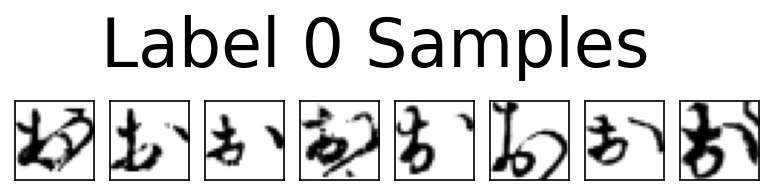

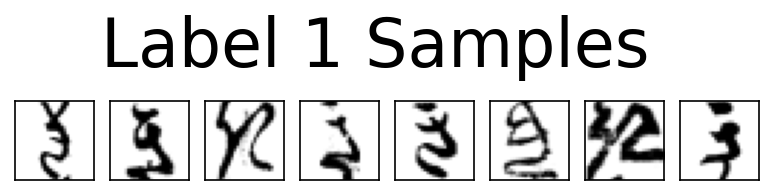

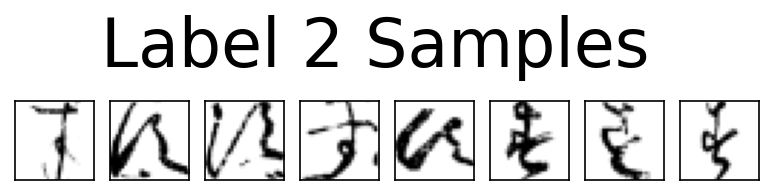

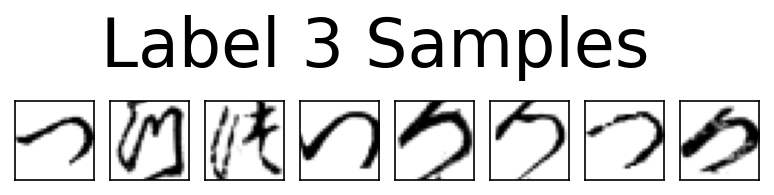

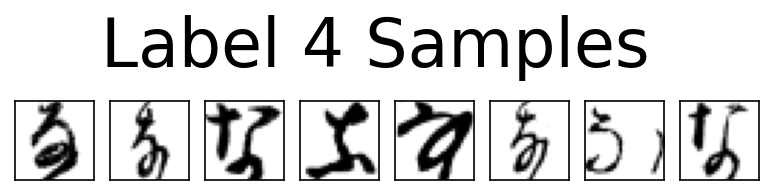

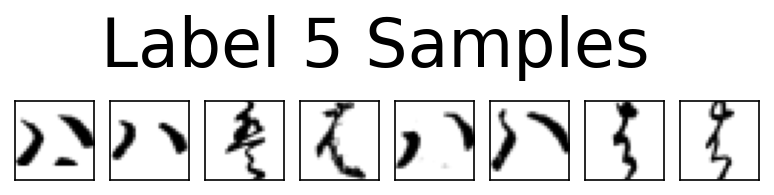

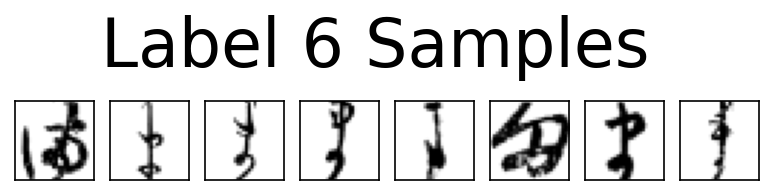

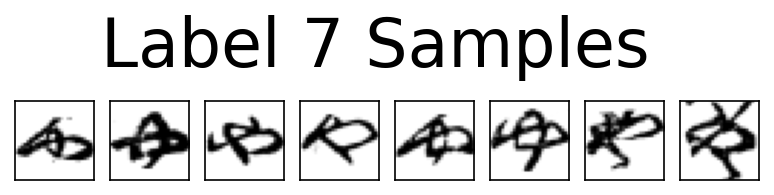

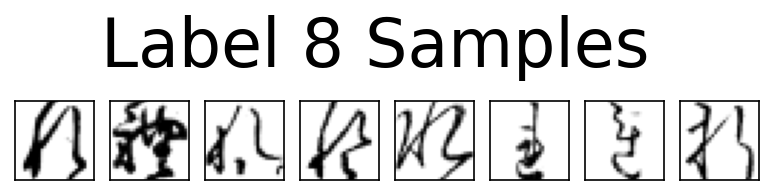

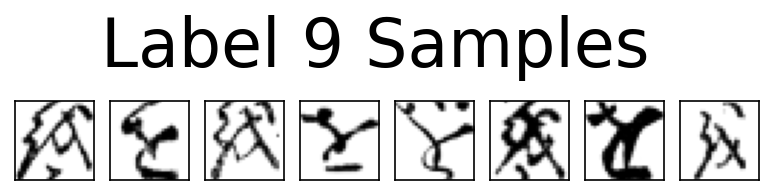

In [38]:
def show_class(label, count=8):
    images = train_X[df_train_y[0] == label]
    fig, axarr = plt.subplots(1, count)
    for index in range(0, count):
        pixels = images[index]
        axarr[index].imshow(pixels, cmap='gray_r', vmin=0, vmax=255)
        axarr[index].tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig.suptitle(f"Label {label} Samples", fontsize=32)
    plt.subplots_adjust(top=1.5)
    plt.show()
for label in range(0, 10):
    show_class(label)

Let us finish preparing our data by converting to 4D tensors (with final channel size of 1) and scaling our grayscale pixels from 0-255 (int) to 0-1 (float).

In [6]:
keras_train_X = train_X.reshape(60000, 28, 28, 1) / 255.0
keras_test_X = test_X.reshape(10000, 28, 28, 1) / 255.0
keras_train_y = keras.utils.to_categorical(train_y, num_classes=10)
keras_test_y = keras.utils.to_categorical(test_y, num_classes=10)
print(f"New shapes, train X {keras_train_X.shape} y {keras_train_y.shape}, test X {keras_test_X.shape} y {keras_test_y.shape}")

New shapes, train X (60000, 28, 28, 1) y (60000, 10), test X (10000, 28, 28, 1) y (10000, 10)


Let us define a helper function for evaluating our models.

In [39]:
def plot_loss_accuracy(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Let us define a helper function to show the confusion matrix for our models.

In [54]:
def plot_confusion_matrix(model):
    predicted_y = model.predict(keras_test_X)
    predicted_labels = np.argmax(predicted_y, axis=1)
    true_labels = np.argmax(keras_test_y, axis=1)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    plt.imshow(conf_matrix, cmap=plt.cm.Blues)
    thresh = conf_matrix.max() / 2
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(
                j,
                i,
                format(conf_matrix[i, j], 'd'),
                ha="center",
                va="center",
                color="white" if conf_matrix[i, j] > thresh else "black"
            )
    plt.colorbar()
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(np.arange(10), rotation=45)
    plt.yticks(np.arange(10))
    plt.tight_layout()
    plt.show()

## DNNs

Now let us create our initial model using a flatten layer, 2 dense 8 node layers, and a 10 node output layer.

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_14 (Flatten)                 │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 8)                   │           6,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 10)                  │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,442 (25.16 KB)

 Trainable params: 6,442 (25.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3846 - loss: 1.7325 - val_accuracy: 0.7005 - val_loss: 1.0177
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.7325 - loss: 0.9168 - val_accuracy: 0.7705 - val_loss: 0.7997
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.7827 - loss: 0.7472 - val_accuracy: 0.7897 - val_loss: 0.7347
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.7925 - loss: 0.6987 - val_accuracy: 0.7972 - val_loss: 0.6973
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.7986 - loss: 0.6726 - val_accuracy: 0.8050 - val_loss: 0.6753
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - accuracy: 0.8077 - loss: 0.6487 - val_accuracy: 0.8126 - val_loss: 0.6561
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.8152 - loss: 0.6194 - val_accuracy: 0.8164 - val_loss: 0.6437
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - accuracy: 0.8147 - loss: 0.6190 - va

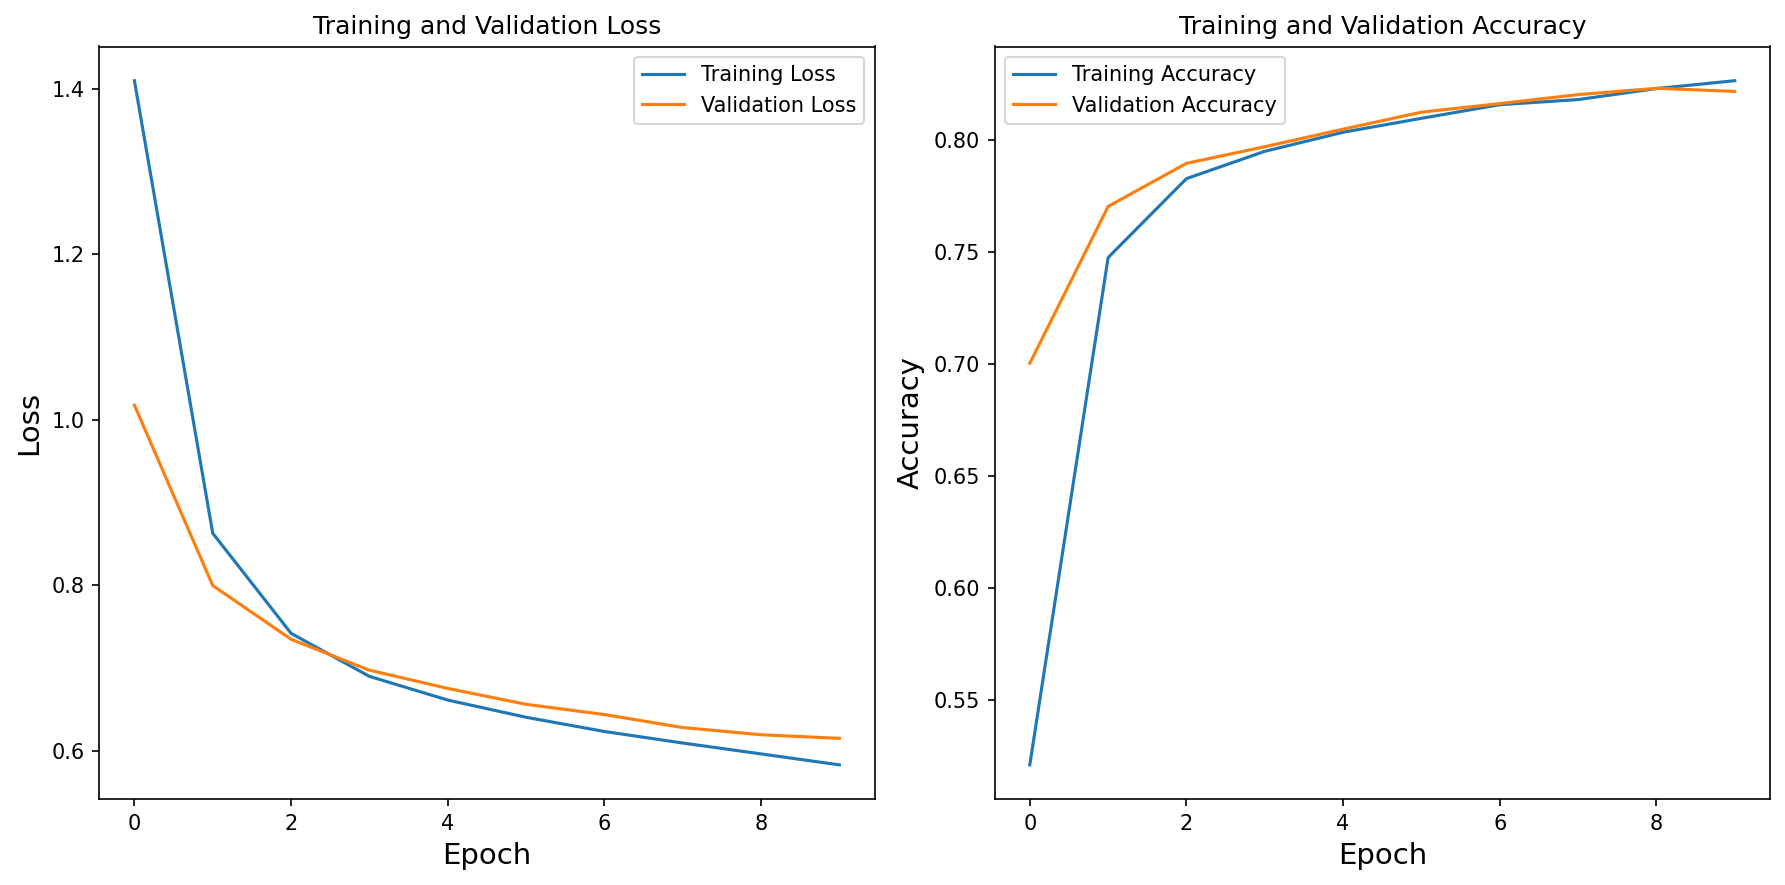

Test Accuracy 68.4%


In [43]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(28,28,1)),
    keras.layers.Flatten(),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(keras_train_X, keras_train_y, epochs=10, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

Our initial model had an accuracy of 82.7% after 10 epochs.  Let us explore differences with number of training epochs, number of hidden layers, size of initial hidden layers, and the optimizer.

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_15 (Flatten)                 │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 8)                   │           6,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 10)                  │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,442 (25.16 KB)

 Trainable params: 6,442 (25.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4224 - loss: 1.6981 - val_accuracy: 0.6902 - val_loss: 1.0157
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - accuracy: 0.7170 - loss: 0.9245 - val_accuracy: 0.7613 - val_loss: 0.8177
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.7781 - loss: 0.7610 - val_accuracy: 0.7880 - val_loss: 0.7464
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.7926 - loss: 0.7033 - val_accuracy: 0.7913 - val_loss: 0.7120
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - accuracy: 0.8022 - loss: 0.6728 - val_accuracy: 0.7995 - val_loss: 0.6889
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.8082 - loss: 0.6471 - val_accuracy: 0.8026 - val_loss: 0.6731
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.8136 - loss: 0.6292 - val_accuracy: 0.8070 - val_loss: 0.6516
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.8179 - loss: 0.6036 - va

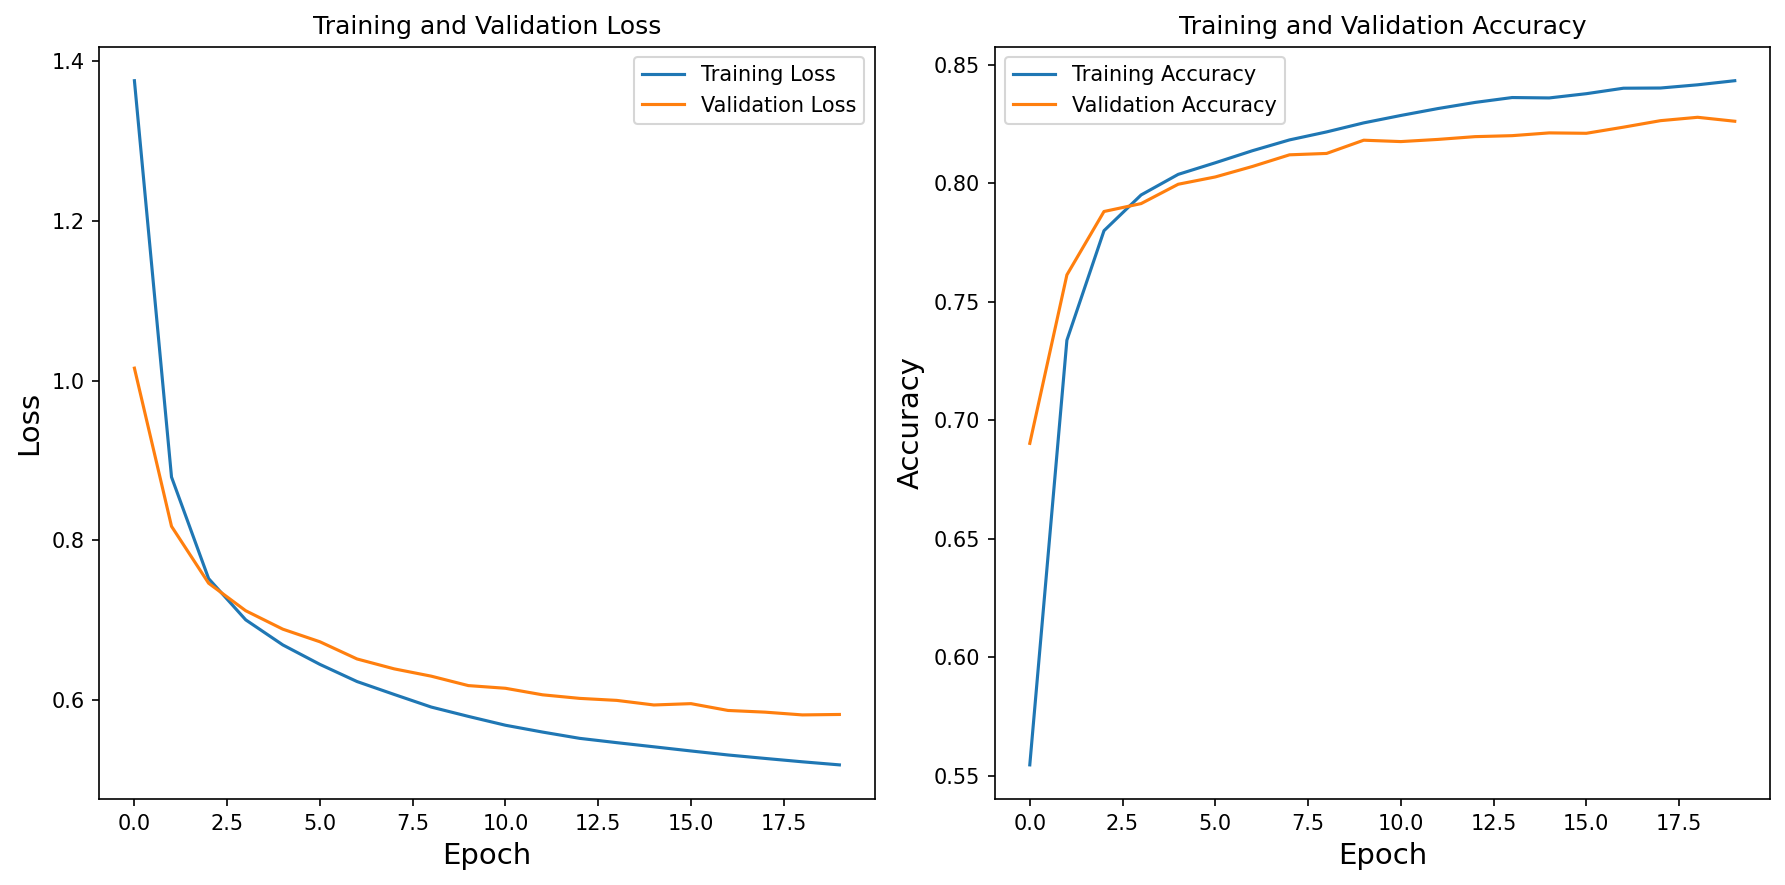

Test Accuracy 66.8%


In [44]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(28,28,1)),
    keras.layers.Flatten(),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=20, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

Doubling the number of epochs only appeared to increase the model accuracy by 2% (to 84.8%) and we can also see that the validation accuracy stopped growing.

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_16 (Flatten)                 │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 10)                  │           7,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6152 - loss: 1.2604 - val_accuracy: 0.7980 - val_loss: 0.7023
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.8065 - loss: 0.6652 - val_accuracy: 0.8123 - val_loss: 0.6497
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.8159 - loss: 0.6199 - val_accuracy: 0.8167 - val_loss: 0.6299
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - accuracy: 0.8242 - loss: 0.5935 - val_accuracy: 0.8207 - val_loss: 0.6209
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.8260 - loss: 0.5926 - val_accuracy: 0.8223 - val_loss: 0.6139
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - accuracy: 0.8311 - loss: 0.5781 - val_accuracy: 0.8231 - val_loss: 0.6128
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.8312 - loss: 0.5729 - val_accuracy: 0.8243 - val_loss: 0.6087
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.8324 - loss: 0.5671 - va

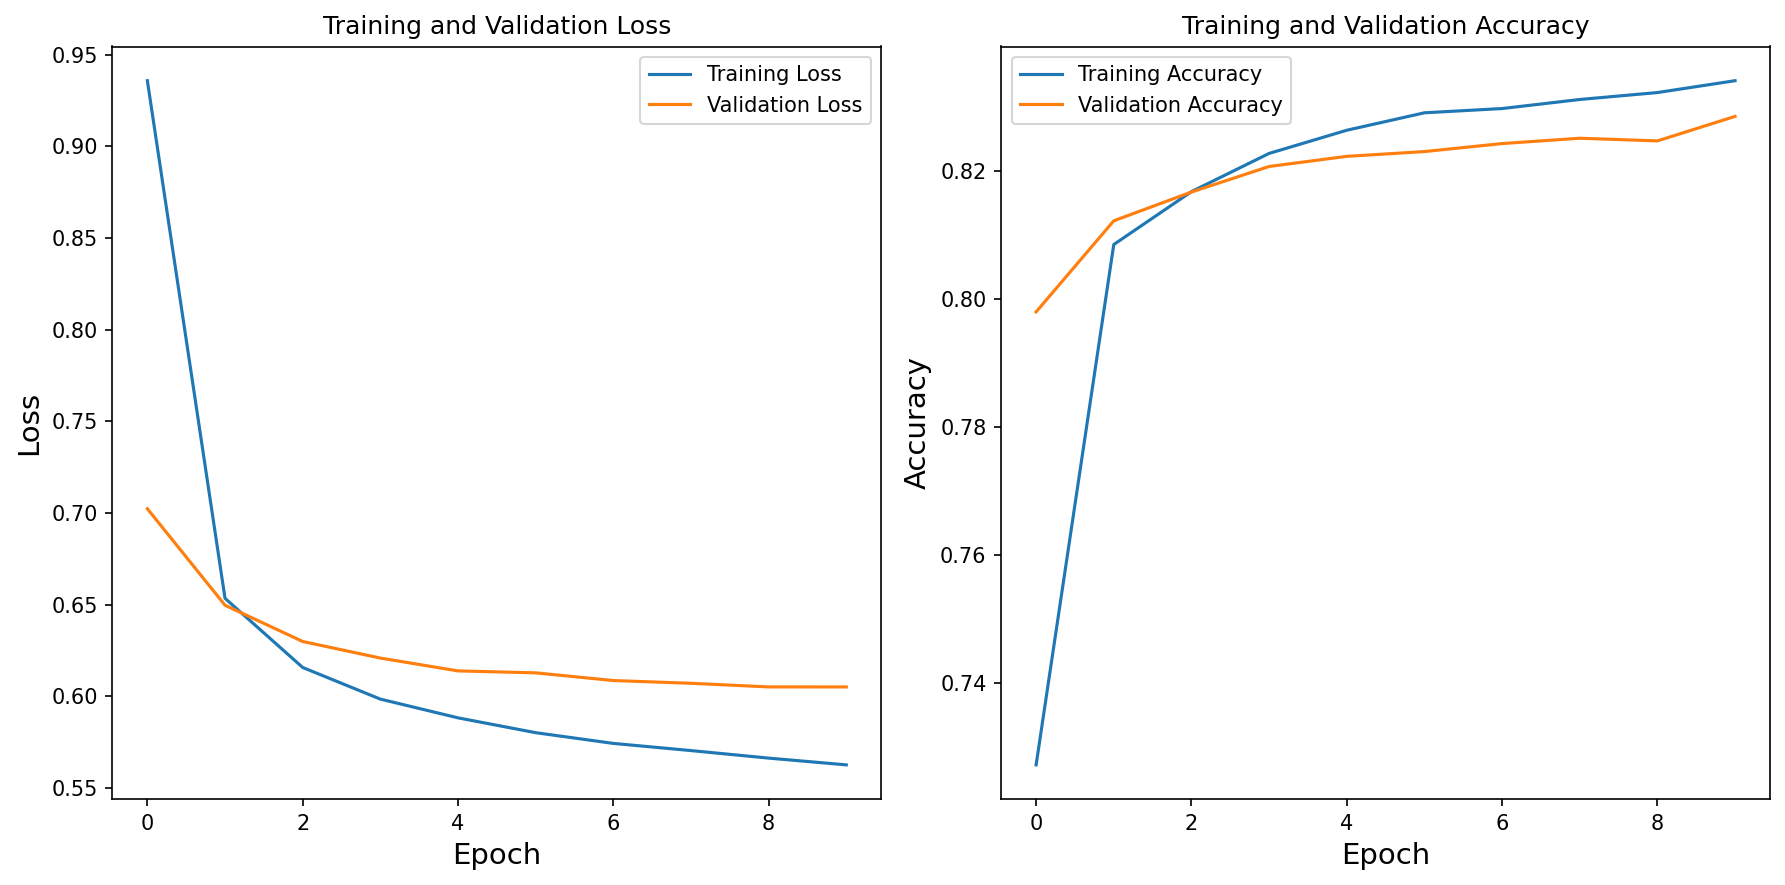

Test Accuracy 70.0%


In [45]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(28,28,1)),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=10, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

Having no hidden layers was able to get an accuracy of 83.9%.  This was a suprising result.

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_17 (Flatten)                 │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 8)                   │           6,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 10)                  │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,586 (25.73 KB)

 Trainable params: 6,586 (25.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2853 - loss: 1.8836 - val_accuracy: 0.6607 - val_loss: 1.0250
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - accuracy: 0.6986 - loss: 0.9238 - val_accuracy: 0.7535 - val_loss: 0.7818
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - accuracy: 0.7691 - loss: 0.7325 - val_accuracy: 0.7779 - val_loss: 0.7169
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7876 - loss: 0.6818 - val_accuracy: 0.7863 - val_loss: 0.6837
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8005 - loss: 0.6356 - val_accuracy: 0.7940 - val_loss: 0.6668
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.8129 - loss: 0.6088 - val_accuracy: 0.7964 - val_loss: 0.6581
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8146 - loss: 0.6037 - val_accuracy: 0.8009 - val_loss: 0.6473
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8209 - loss: 0.5851 - val_accura

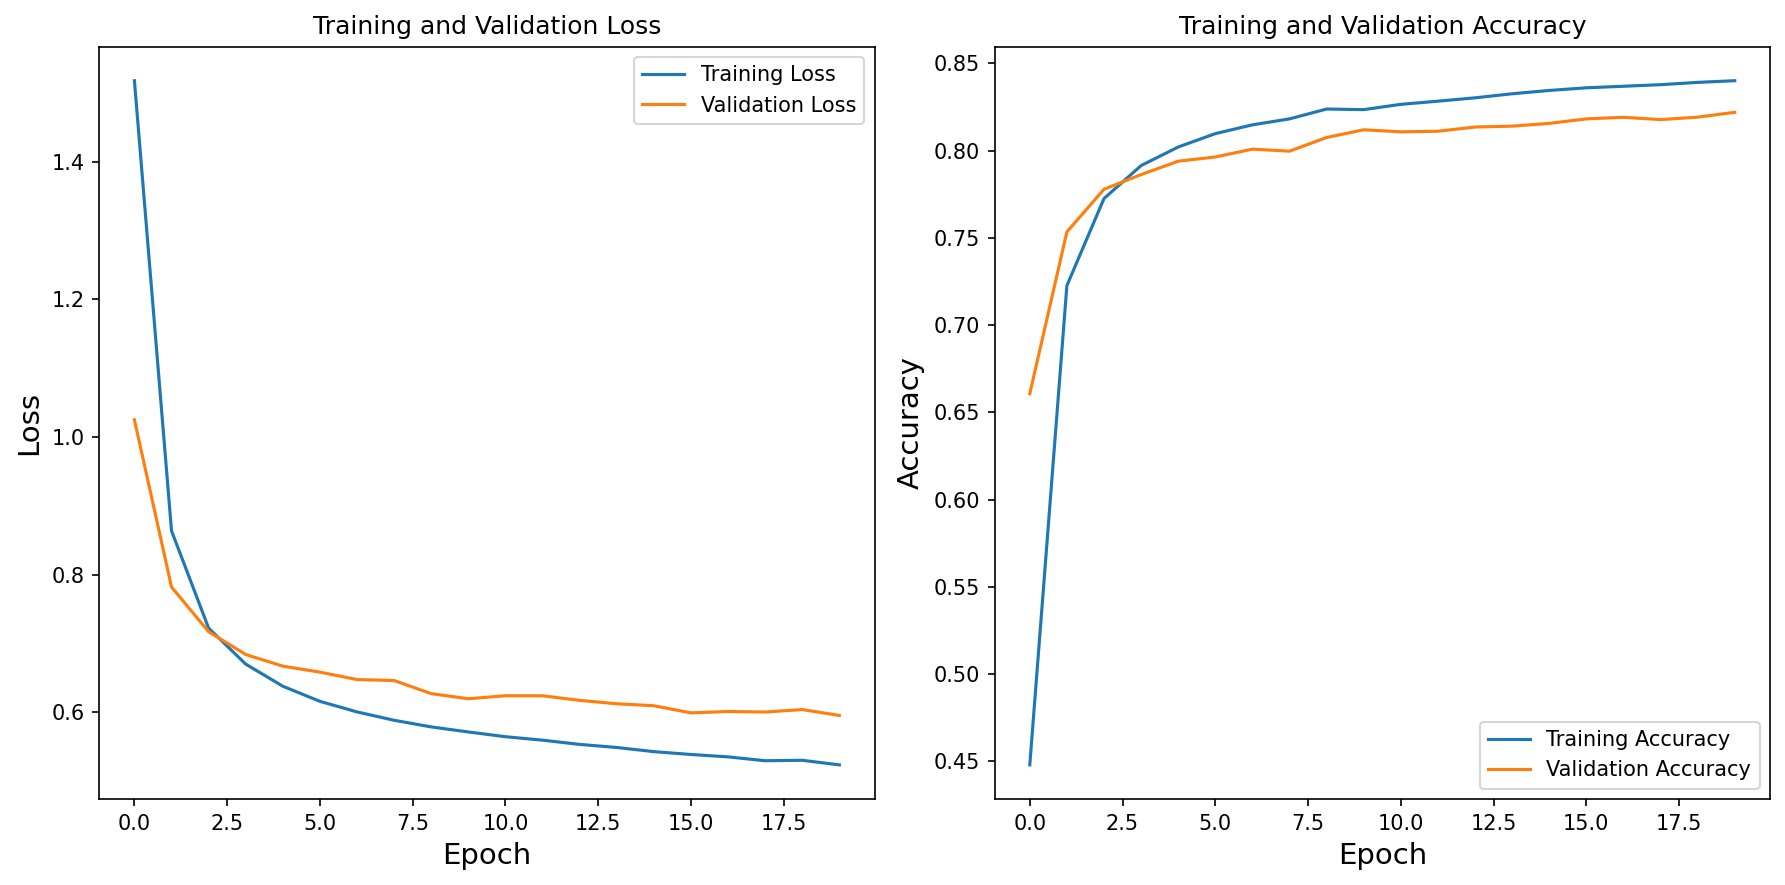

Test Accuracy 66.8%


In [46]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(28,28,1)),
    keras.layers.Flatten(),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=20, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

A network with four hidden layers and using 20 epochs was able to get an accuracy of 84.4% but only had an accuracy of 82.6% by epoch 10.

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_18 (Flatten)                 │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 10)                  │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,002 (429.70 KB)

 Trainable params: 110,002 (429.70 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5787 - loss: 1.2371 - val_accuracy: 0.8892 - val_loss: 0.3966
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9053 - loss: 0.3370 - val_accuracy: 0.9206 - val_loss: 0.2866
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9353 - loss: 0.2277 - val_accuracy: 0.9305 - val_loss: 0.2458
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9528 - loss: 0.1679 - val_accuracy: 0.9321 - val_loss: 0.2344
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9615 - loss: 0.1359 - val_accuracy: 0.9353 - val_loss: 0.2205
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9715 - loss: 0.1023 - val_accuracy: 0.9403 - val_loss: 0.2142
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9777 - loss: 0.0796 - val_accuracy: 0.9381 - val_loss: 0.2269
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9818 - loss: 0.0633 - val_accuracy: 0.

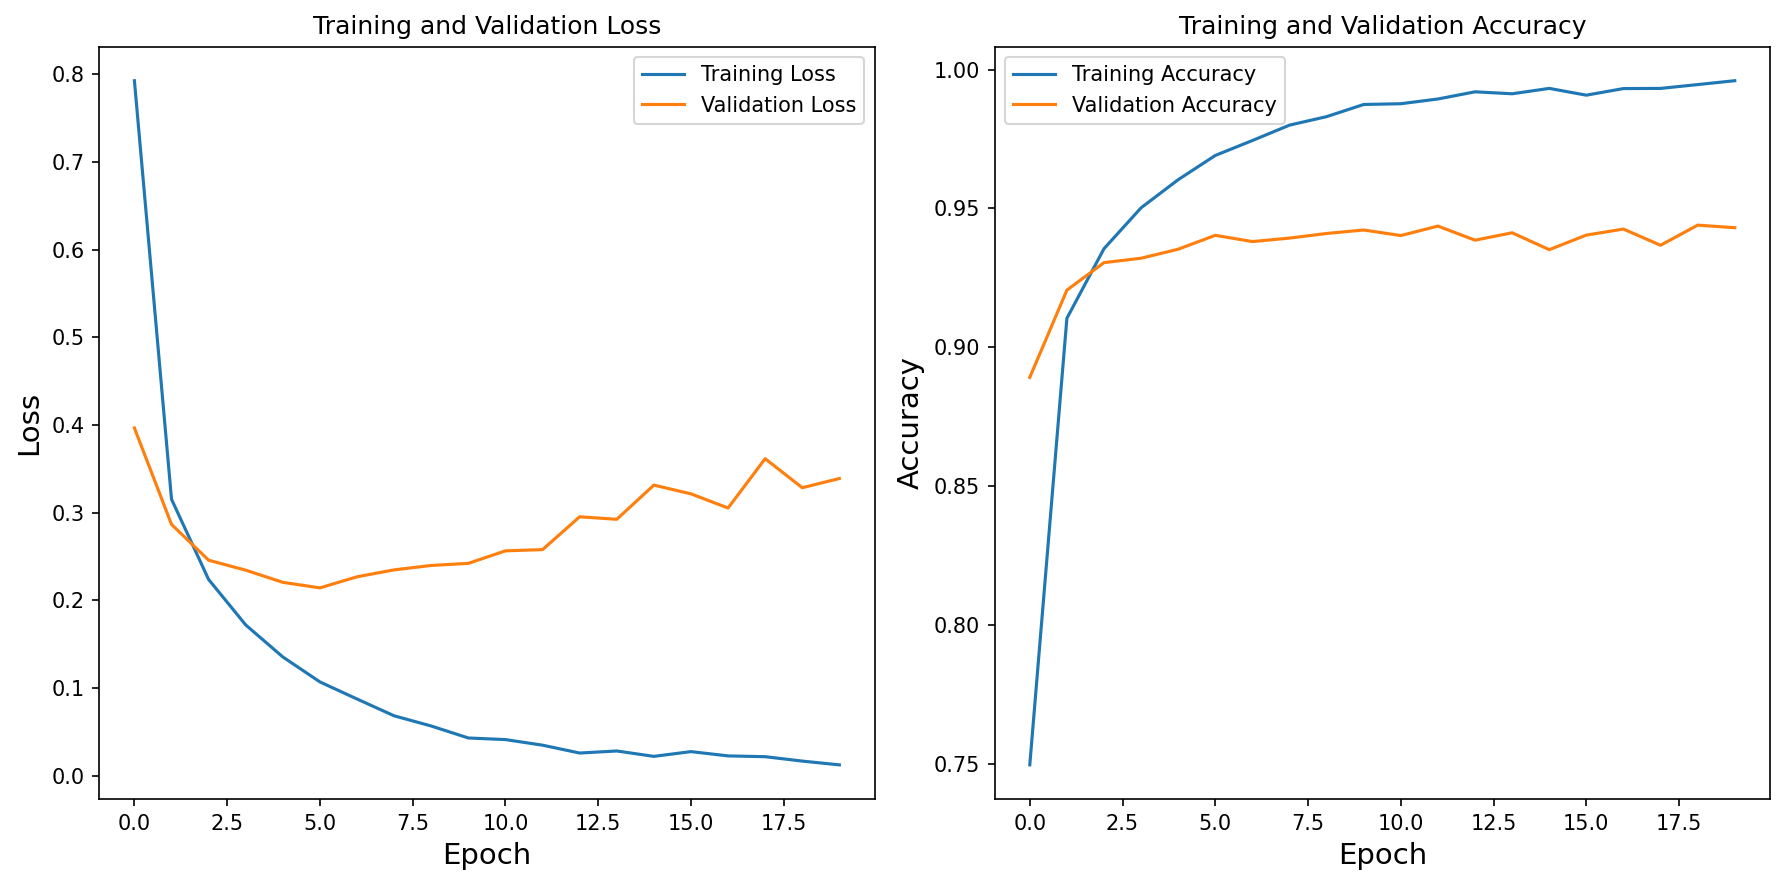

Test Accuracy 86.7%


In [47]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(28,28,1)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=20, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

A network with four hidden layers going from 128 -> 64 -> 16 -> 8 was able to get to 99.5% accuracy in 20 epochs was already at 93.5% by epoch 3 (and 98.8% by epoch 10).  However, looking at the graphs we see that we pretty much started overfitting after the 3rd epoch.

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_19 (Flatten)                 │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 8)                   │           6,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 10)                  │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,442 (25.16 KB)

 Trainable params: 6,442 (25.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3491 - loss: 1.8987 - val_accuracy: 0.6558 - val_loss: 1.1694
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.6856 - loss: 1.0714 - val_accuracy: 0.7219 - val_loss: 0.9256
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.7364 - loss: 0.8817 - val_accuracy: 0.7455 - val_loss: 0.8428
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.7496 - loss: 0.8212 - val_accuracy: 0.7628 - val_loss: 0.7970
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.7707 - loss: 0.7659 - val_accuracy: 0.7703 - val_loss: 0.7659
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.7801 - loss: 0.7334 - val_accuracy: 0.7807 - val_loss: 0.7348
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.7831 - loss: 0.7190 - val_accuracy: 0.7859 - val_loss: 0.7157
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.7912 - loss: 0.6894 - va

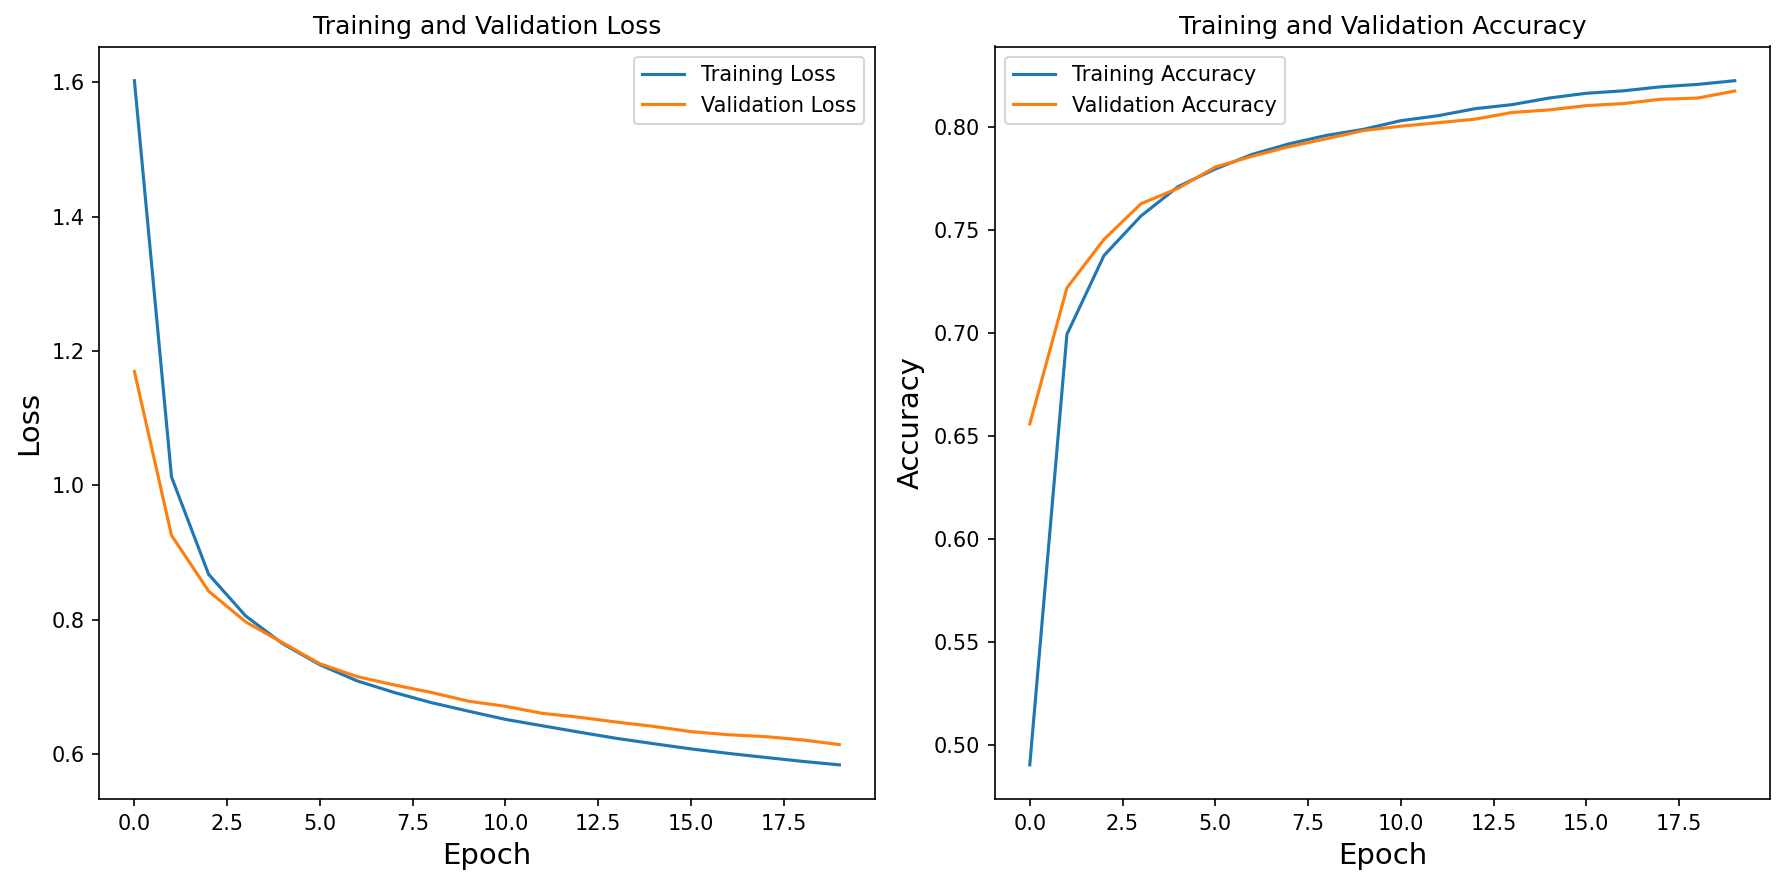

Test Accuracy 68.2%


In [48]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(28,28,1)),
    keras.layers.Flatten(),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=20, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

Going back to the original network structure of two dense 8 node layers, we have switched the optimizer to `adamax`.  This only got an 82.5% accuracy by epoch 20 and only 80.5% by epoch 10.  However, it appeared to have a great accuracy vs. validation curve.  That didn't matter for the resulting 68.2% test accuracy.

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_20 (Flatten)                 │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 8)                   │           6,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 10)                  │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,442 (25.16 KB)

 Trainable params: 6,442 (25.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1847 - loss: 2.2247 - val_accuracy: 0.3301 - val_loss: 1.8832
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.4001 - loss: 1.7808 - val_accuracy: 0.5309 - val_loss: 1.5225
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.5528 - loss: 1.4564 - val_accuracy: 0.6107 - val_loss: 1.2833
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6271 - loss: 1.2296 - val_accuracy: 0.6646 - val_loss: 1.1195
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.6768 - loss: 1.0798 - val_accuracy: 0.7023 - val_loss: 1.0078
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.7063 - loss: 0.9807 - val_accuracy: 0.7287 - val_loss: 0.9253
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.7367 - loss: 0.8872 - val_accuracy: 0.7512 - val_loss: 0.8558
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.7571 - loss: 0.8303 - val_

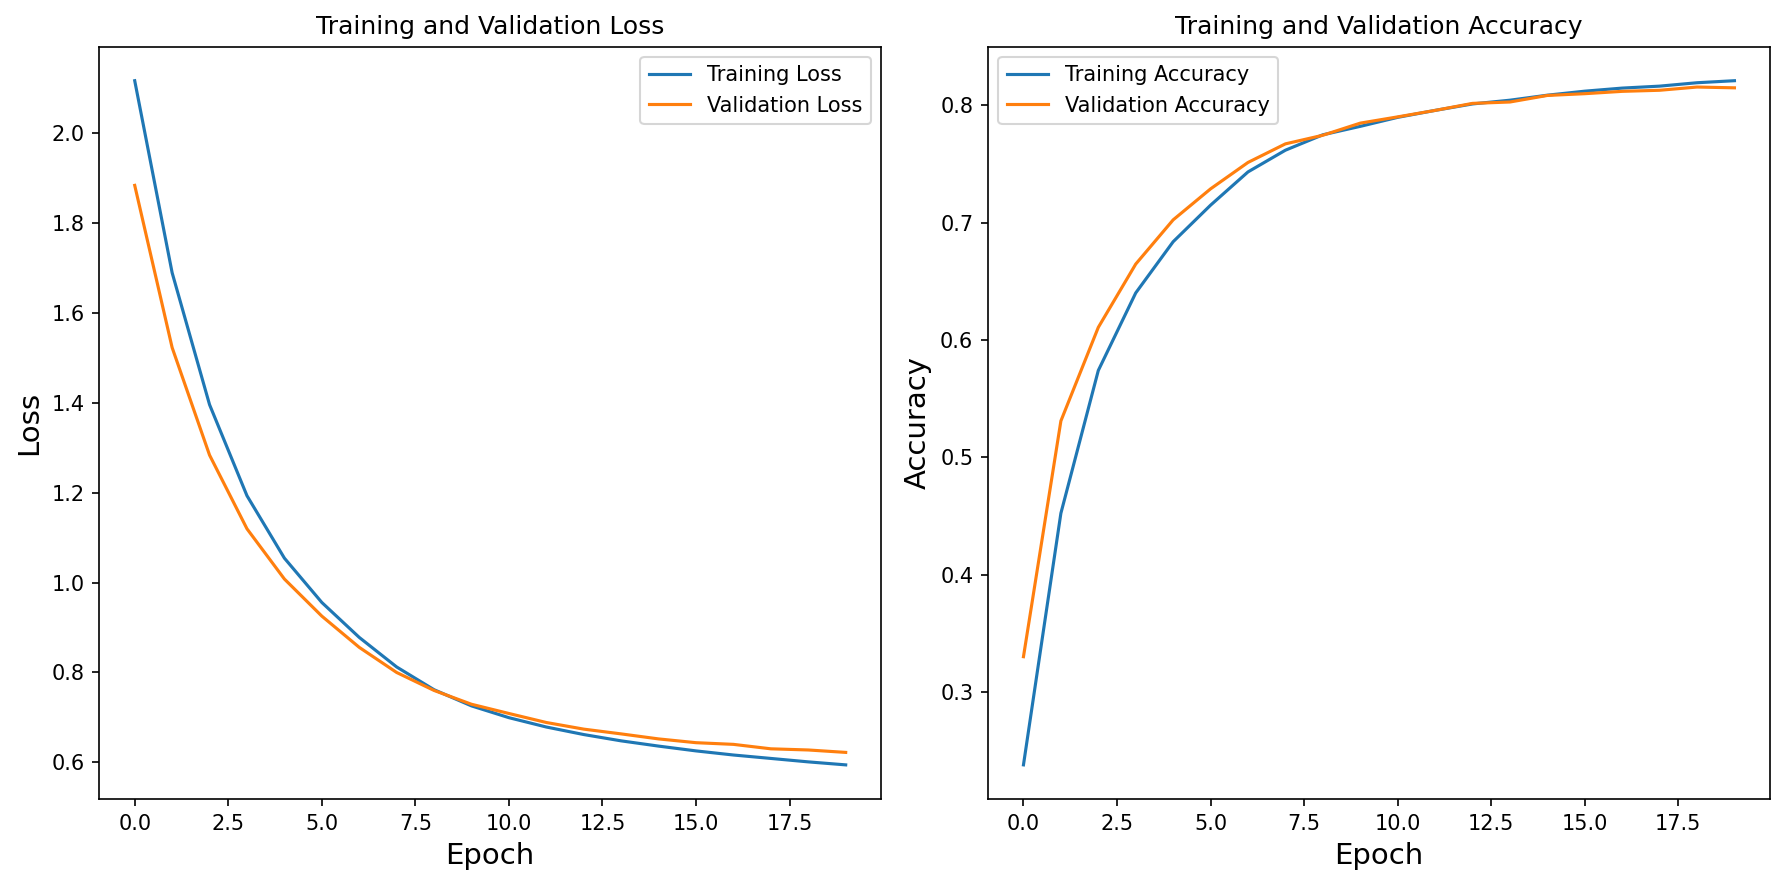

Test Accuracy 66.8%


In [49]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(28,28,1)),
    keras.layers.Flatten(),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=20, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

The SGD optimizer performed even worse with a final accuracy of 79% at epoch 20 and only 74.7% at epoch 10.

Let us go back to the best model but lower the epochs to 3 to prevent overfitting and try it against our test dataset.

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_23 (Flatten)                 │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 10)                  │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,002 (429.70 KB)

 Trainable params: 110,002 (429.70 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5266 - loss: 1.3668 - val_accuracy: 0.8743 - val_loss: 0.4460
Epoch 2/3
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8967 - loss: 0.3572 - val_accuracy: 0.9168 - val_loss: 0.2933
Epoch 3/3
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9323 - loss: 0.2330 - val_accuracy: 0.9275 - val_loss: 0.2542


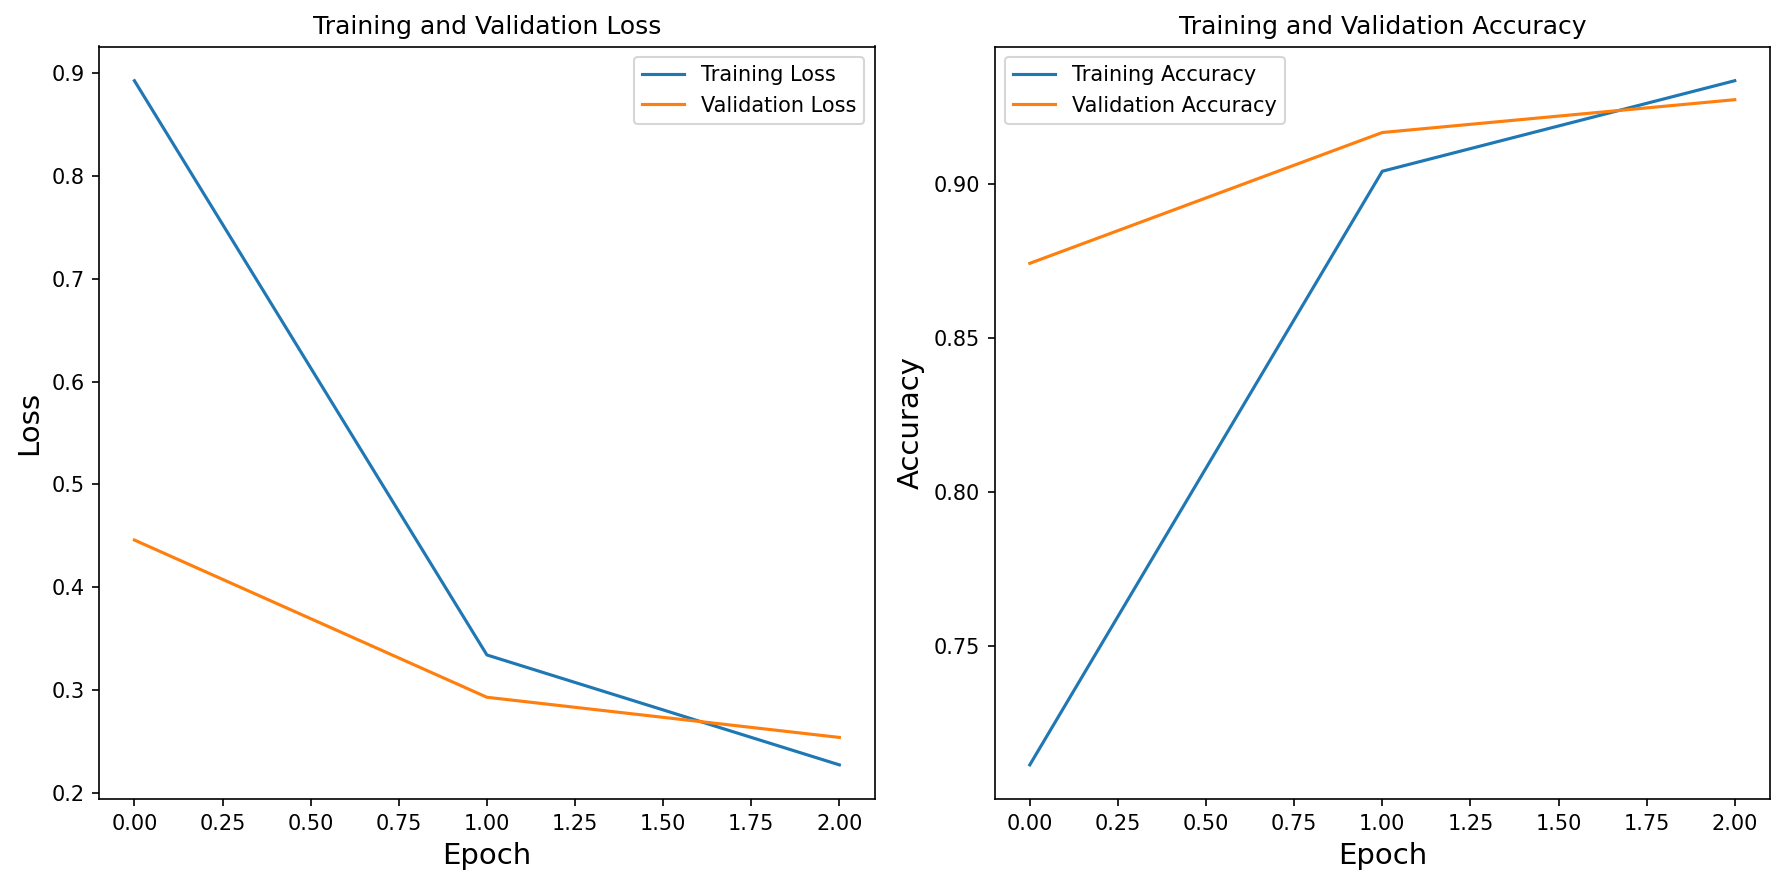

Test Accuracy 84.4%


In [52]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(28,28,1)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=3, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


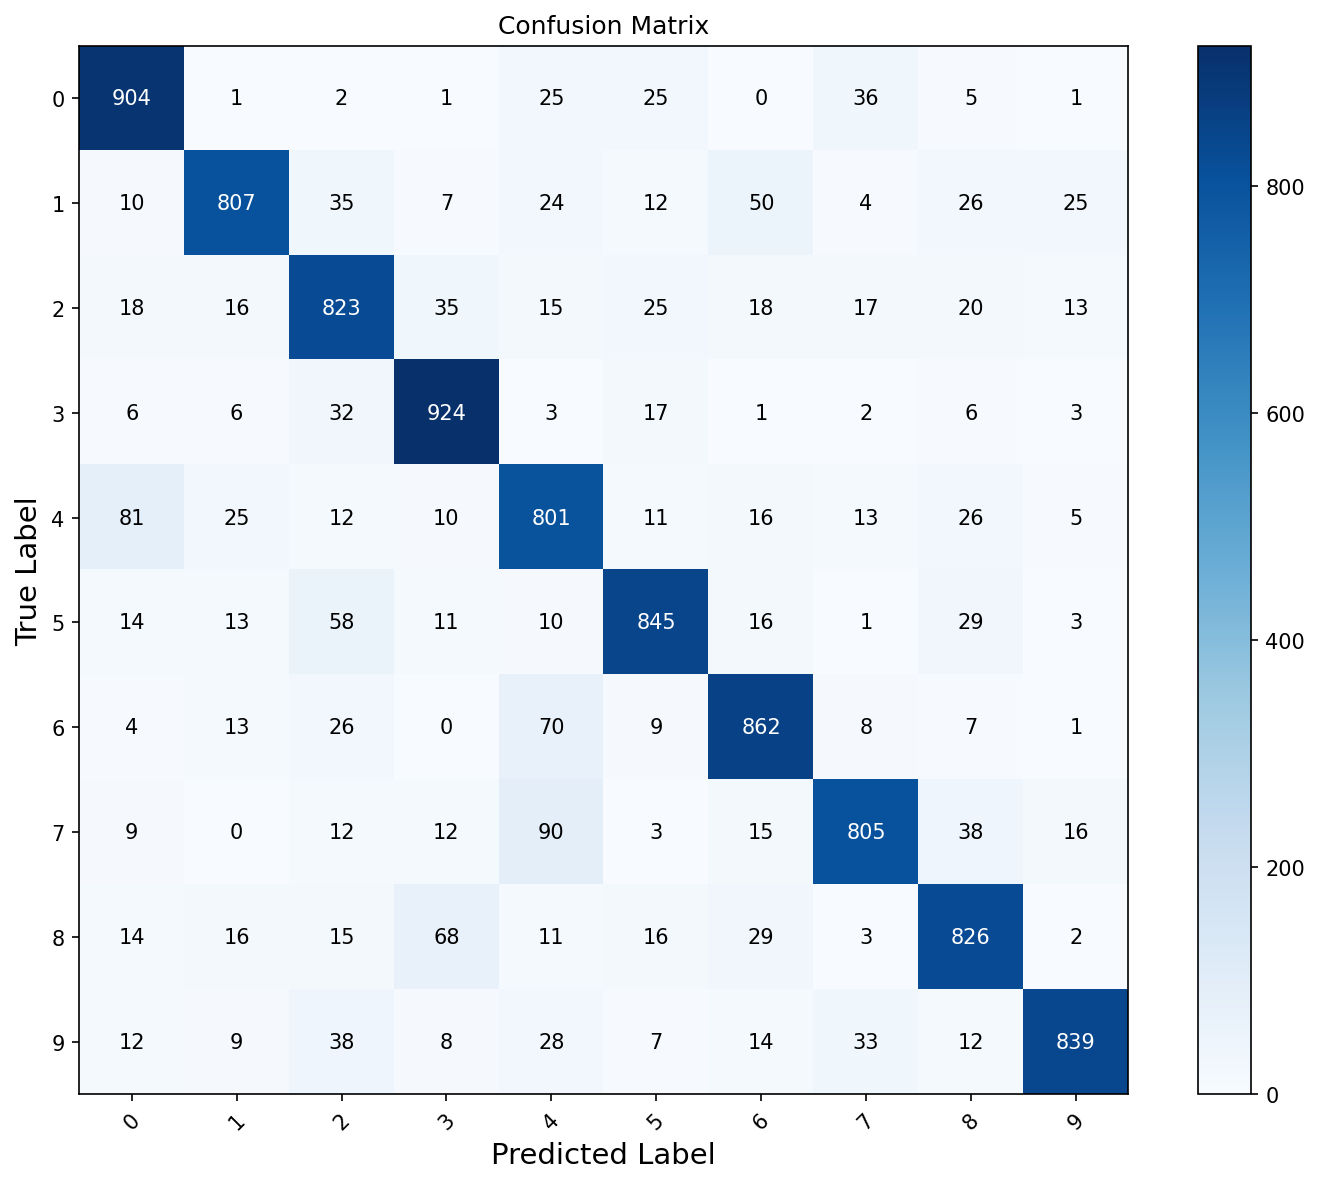

In [55]:
plot_confusion_matrix(model)

We had an overall testing accuracy of 84.4% which is not too bad.  But we are always looking for 100%!  Let us now explore how CNNs perform.

## CNNs

Let us start with a CNN with 2 conv layers, 1 max pooling layer, a flatten layer, 2 dense layers of size 128/64, and a 10 node output layer.

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_24 (Flatten)                 │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_87 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_88 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 305,194 (1.16 MB)

 Trainable params: 305,194 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7766 - loss: 0.7571 - val_accuracy: 0.9457 - val_loss: 0.1897
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9562 - loss: 0.1460 - val_accuracy: 0.9650 - val_loss: 0.1241
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9771 - loss: 0.0781 - val_accuracy: 0.9685 - val_loss: 0.1094
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9861 - loss: 0.0484 - val_accuracy: 0.9714 - val_loss: 0.1036
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9913 - loss: 0.0303 - val_accuracy: 0.9718 - val_loss: 0.1060
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9937 - loss: 0.0200 - val_accuracy: 0.9716 - val_loss: 0.1060
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9962 - loss: 0.0126 - val_accuracy: 0.9732 - val_loss: 0.1134
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9961 - loss: 0.0121 - val_accuracy: 0.

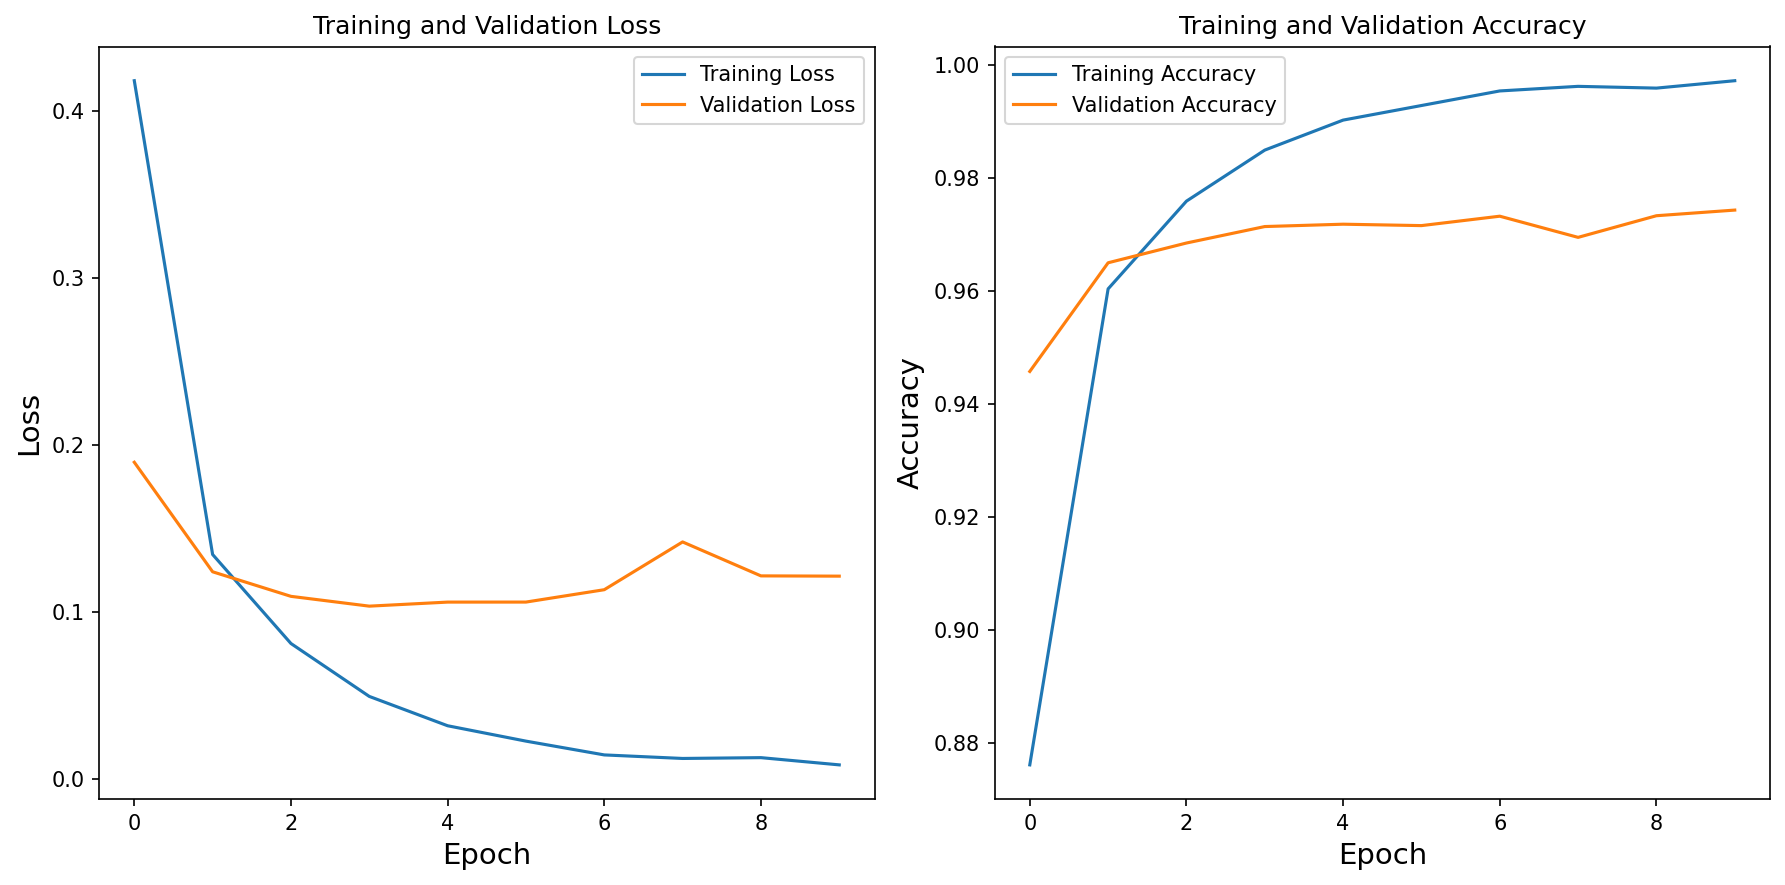

Test Accuracy 92.8%


In [56]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(28,28,1)),
    keras.layers.Conv2D(8, (3, 3), activation='relu'),
    keras.layers.Conv2D(16, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=10, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

We can see that our training model got up to 99.9% but topped out at around a 97.4% validation accuracy.  The testing results were 92.8% accurate which is already much better than our DNN.  We can also see that we topped out our performance around 3 epochs again.

Let us try some variations of the model configuration now and see if we can't optimize our performance.

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_25 (Flatten)                 │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_90 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_91 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 305,194 (1.16 MB)

 Trainable params: 305,194 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6732 - loss: 1.0617 - val_accuracy: 0.8839 - val_loss: 0.3834
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9057 - loss: 0.3114 - val_accuracy: 0.9304 - val_loss: 0.2317
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9404 - loss: 0.1991 - val_accuracy: 0.9458 - val_loss: 0.1813
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9539 - loss: 0.1564 - val_accuracy: 0.9544 - val_loss: 0.1524
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9621 - loss: 0.1280 - val_accuracy: 0.9595 - val_loss: 0.1344
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9717 - loss: 0.0971 - val_accuracy: 0.9597 - val_loss: 0.1302
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9767 - loss: 0.0812 - val_accuracy: 0.9660 - val_loss: 0.1153
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9791 - loss: 0.0699 - val_accuracy: 0.

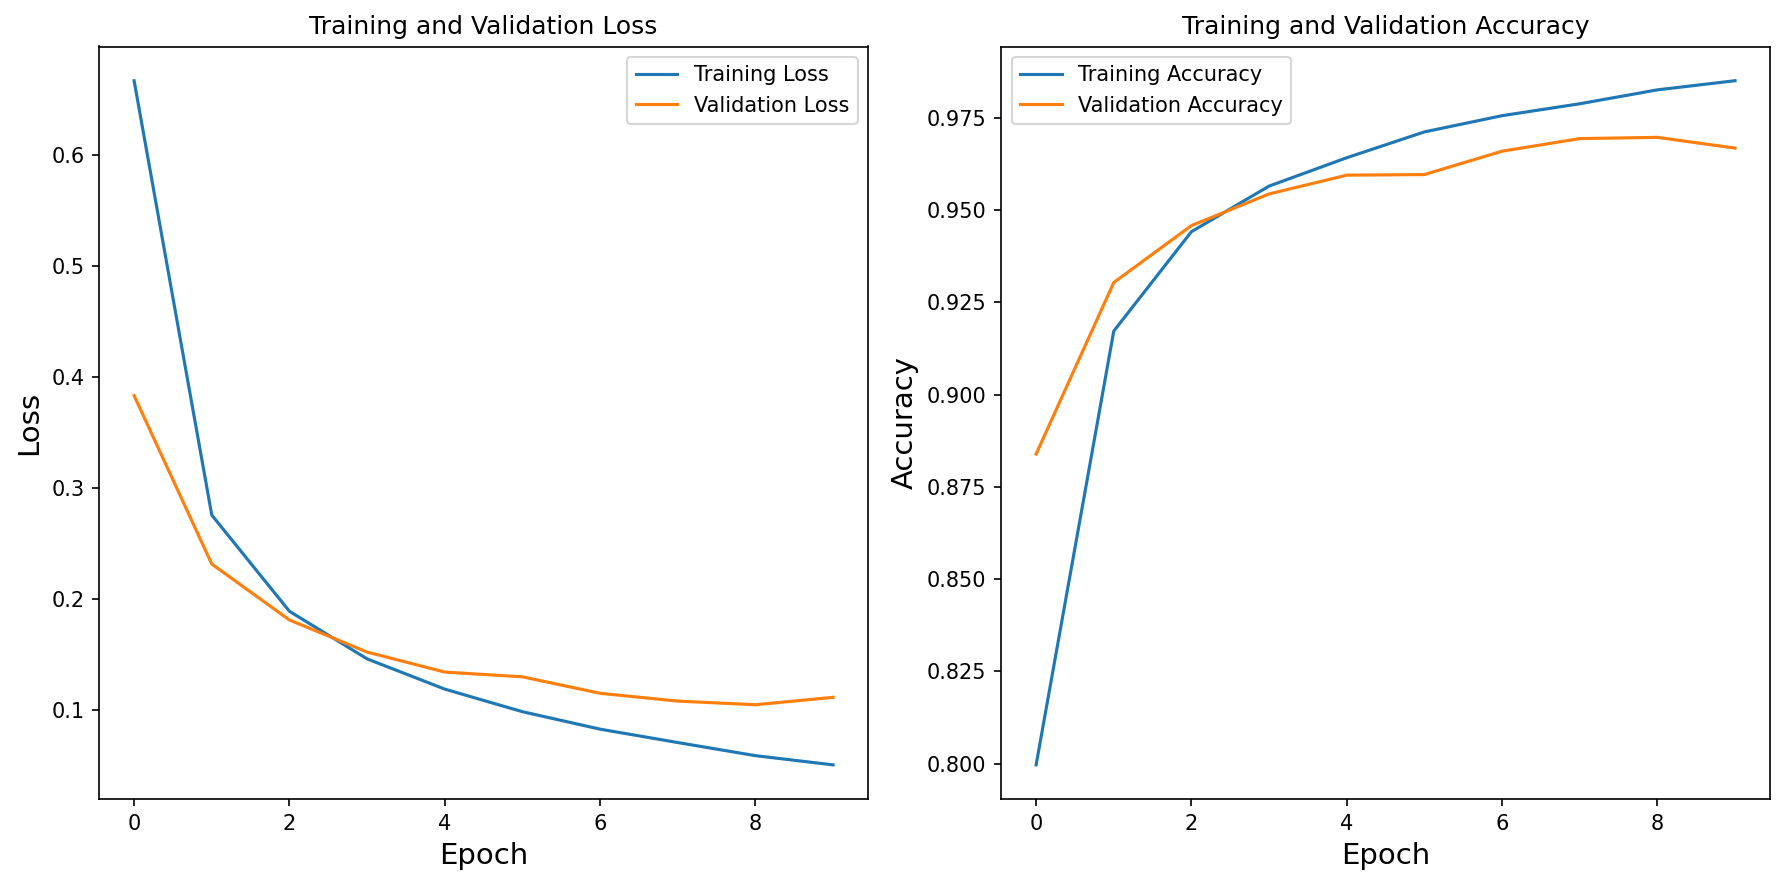

Test Accuracy 91.8%


In [57]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(28,28,1)),
    keras.layers.Conv2D(8, (3, 3), activation='relu'),
    keras.layers.Conv2D(16, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=10, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

Using `adamax`, the training curves look better but the overall performance was slightly worse: only 91.8%.

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 26, 26, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_26 (Flatten)                 │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_92 (Dense)                     │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_93 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_94 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 305,194 (1.16 MB)

 Trainable params: 305,194 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3649 - loss: 1.7875 - val_accuracy: 0.8284 - val_loss: 0.5920
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8397 - loss: 0.5295 - val_accuracy: 0.8752 - val_loss: 0.4261
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8747 - loss: 0.4105 - val_accuracy: 0.8923 - val_loss: 0.3588
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9005 - loss: 0.3303 - val_accuracy: 0.9031 - val_loss: 0.3228
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9134 - loss: 0.2879 - val_accuracy: 0.9086 - val_loss: 0.3046
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9237 - loss: 0.2545 - val_accuracy: 0.9232 - val_loss: 0.2571
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9326 - loss: 0.2242 - val_accuracy: 0.9273 - val_loss: 0.2486
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9407 - loss: 0.2009 - val_accuracy: 0.

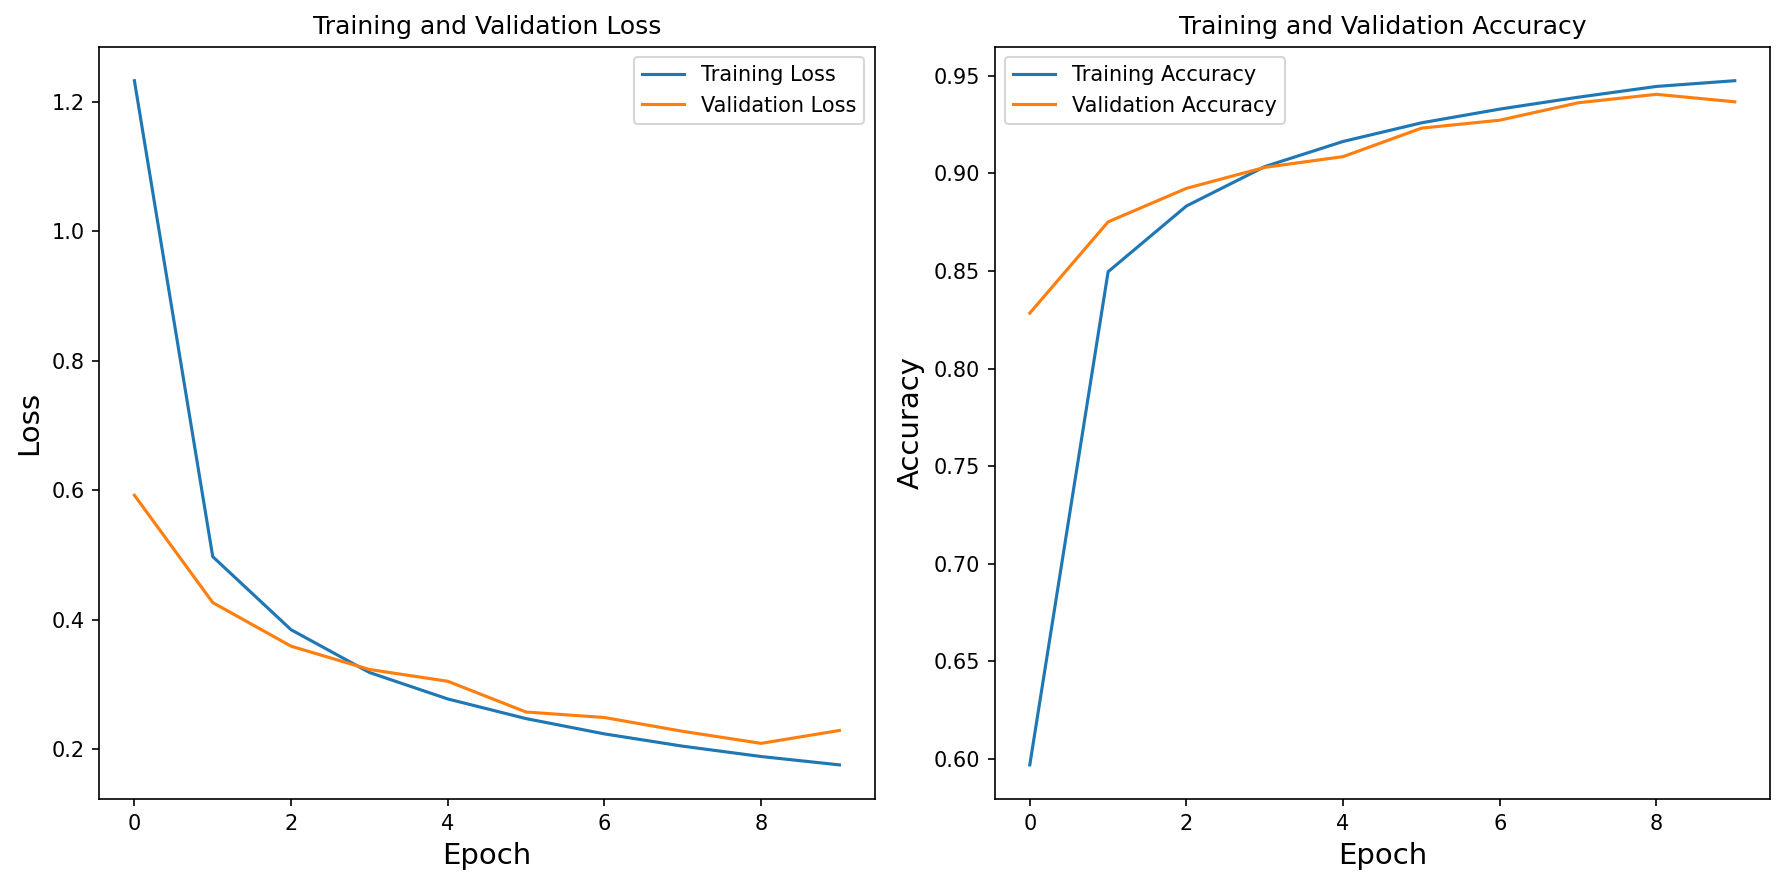

Test Accuracy 85.9%


In [58]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(28,28,1)),
    keras.layers.Conv2D(8, (3, 3), activation='relu'),
    keras.layers.Conv2D(16, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=10, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

SGD dropped way back down to only 85.9% accuracy.  It may have benefitted from more epochs but the difference in validation accuracy and testing accuracy leads me to believe it was still overfitting somehow.

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 26, 26, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_27 (Flatten)                 │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_95 (Dense)                     │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_96 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_97 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 305,194 (1.16 MB)

 Trainable params: 305,194 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7751 - loss: 0.7187 - val_accuracy: 0.9510 - val_loss: 0.1669
Epoch 2/3
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9610 - loss: 0.1357 - val_accuracy: 0.9661 - val_loss: 0.1167
Epoch 3/3
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9785 - loss: 0.0746 - val_accuracy: 0.9668 - val_loss: 0.1173


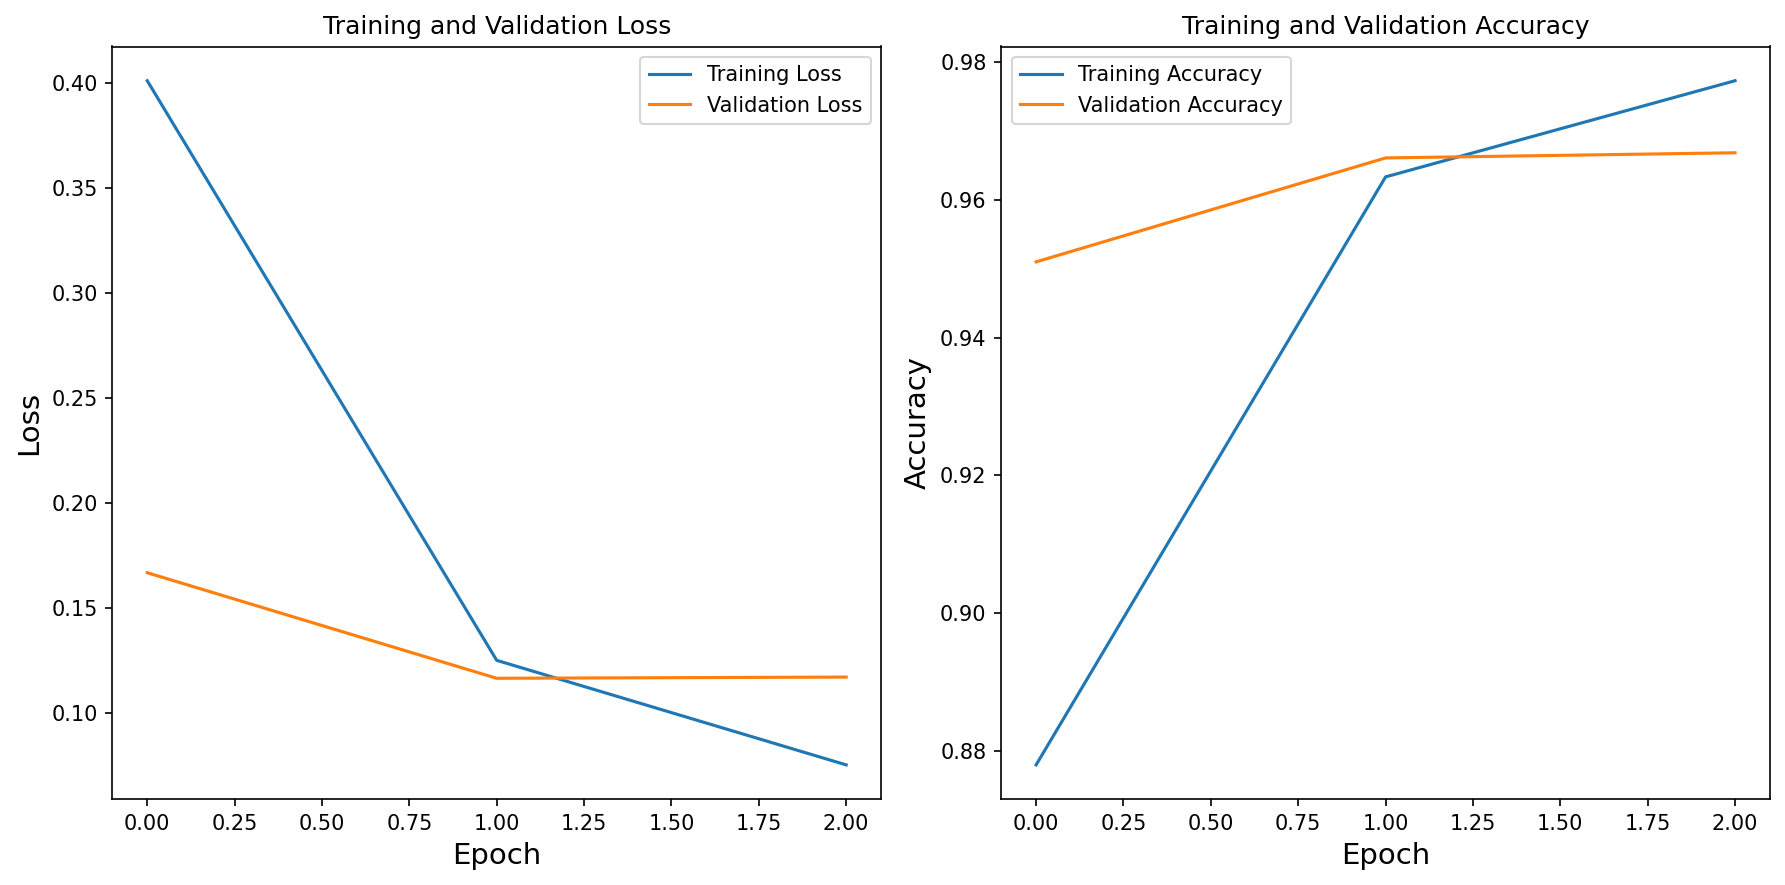

Test Accuracy 91.7%


In [59]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(28,28,1)),
    keras.layers.Conv2D(8, (3, 3), activation='relu'),
    keras.layers.Conv2D(16, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=3, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

Just dropping the number of training epochs to 3 sped up training and only dropped test accuracy to 91.7%.

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 26, 26, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 24, 24, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_28 (Flatten)                 │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_98 (Dense)                     │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_99 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_100 (Dense)                    │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 603,658 (2.30 MB)

 Trainable params: 603,658 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.7915 - loss: 0.6771 - val_accuracy: 0.9466 - val_loss: 0.1730
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9646 - loss: 0.1167 - val_accuracy: 0.9691 - val_loss: 0.1083
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9821 - loss: 0.0590 - val_accuracy: 0.9688 - val_loss: 0.1066
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9907 - loss: 0.0321 - val_accuracy: 0.9725 - val_loss: 0.0998
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9928 - loss: 0.0204 - val_accuracy: 0.9746 - val_loss: 0.0977
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9959 - loss: 0.0131 - val_accuracy: 0.9748 - val_loss: 0.1027
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9969 - loss: 0.0110 - val_accuracy: 0.9764 - val_loss: 0.0992
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9972 - loss: 0.0089 - val_accu

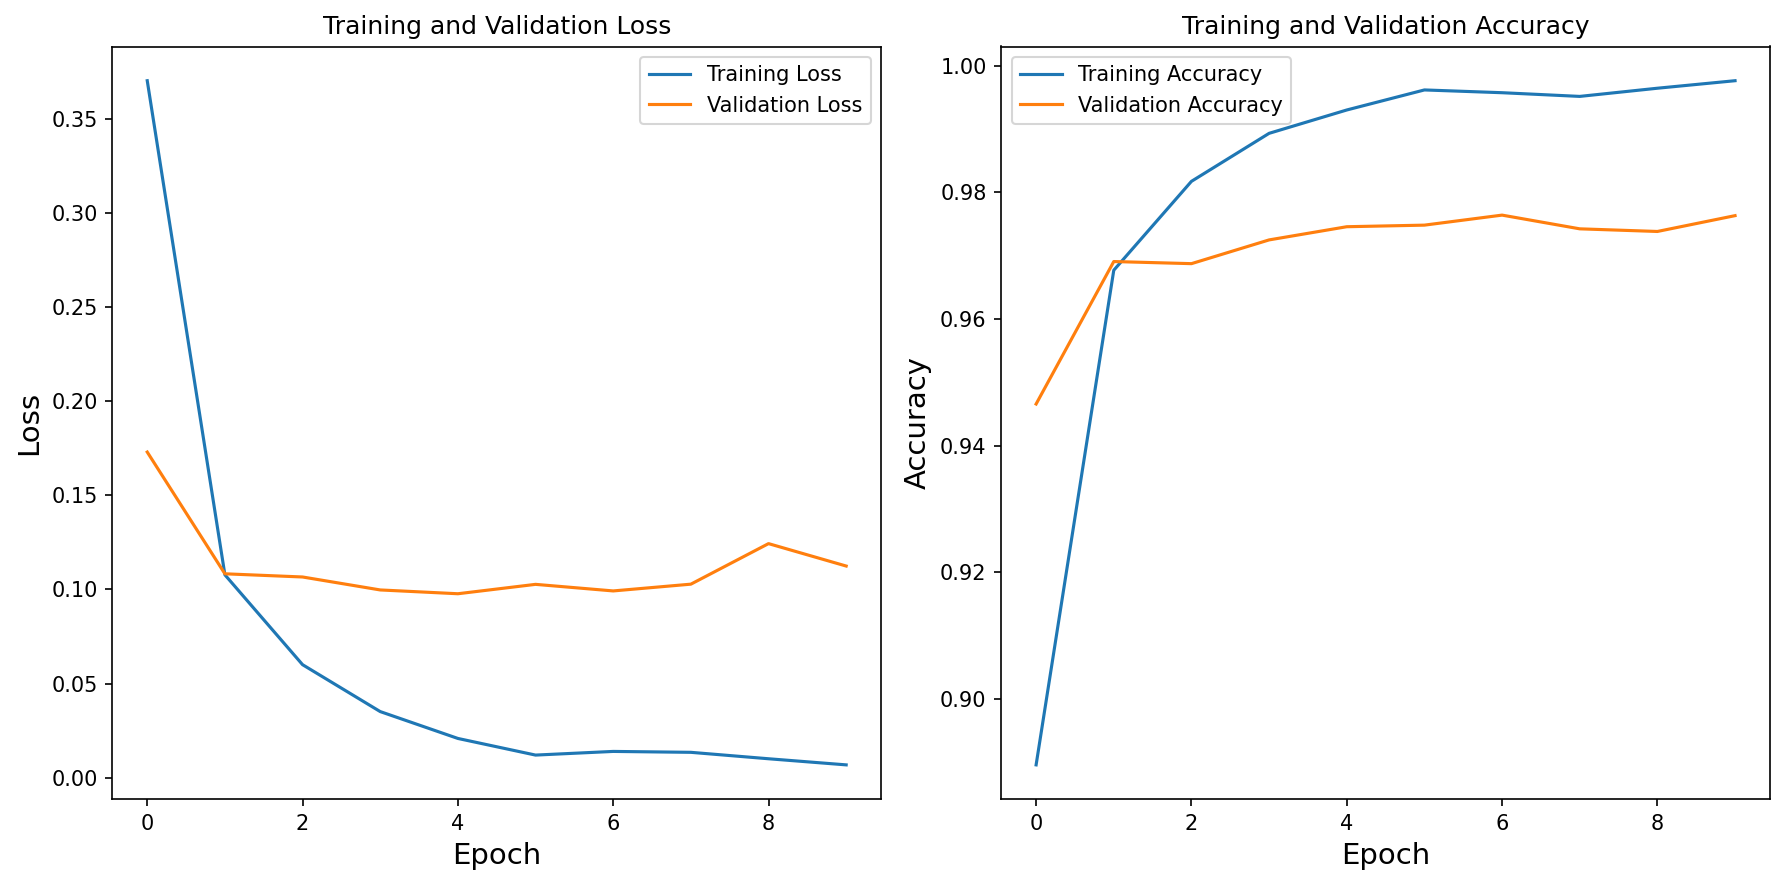

Test Accuracy 93.5%


In [60]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(28,28,1)),
    keras.layers.Conv2D(16, (3, 3), activation='relu'),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=10, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

Doubling the number of kernels in each of the convolution layers improved performance to 93.5% but also doubled the number of parameters being learned.  It also would have benefitted from only 3 training epochs.

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 24, 24, 8)           │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 20, 20, 16)          │           3,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 10, 10, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_29 (Flatten)                 │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_101 (Dense)                    │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_102 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_103 (Dense)                    │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 217,258 (848.66 KB)

 Trainable params: 217,258 (848.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7666 - loss: 0.7464 - val_accuracy: 0.9509 - val_loss: 0.1687
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9600 - loss: 0.1384 - val_accuracy: 0.9653 - val_loss: 0.1173
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9762 - loss: 0.0794 - val_accuracy: 0.9707 - val_loss: 0.1001
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9843 - loss: 0.0516 - val_accuracy: 0.9688 - val_loss: 0.1026
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9889 - loss: 0.0372 - val_accuracy: 0.9721 - val_loss: 0.0957
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9915 - loss: 0.0258 - val_accuracy: 0.9758 - val_loss: 0.0930
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9949 - loss: 0.0178 - val_accuracy: 0.9702 - val_loss: 0.1166
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9950 - loss: 0.0143 - val_accuracy: 0.

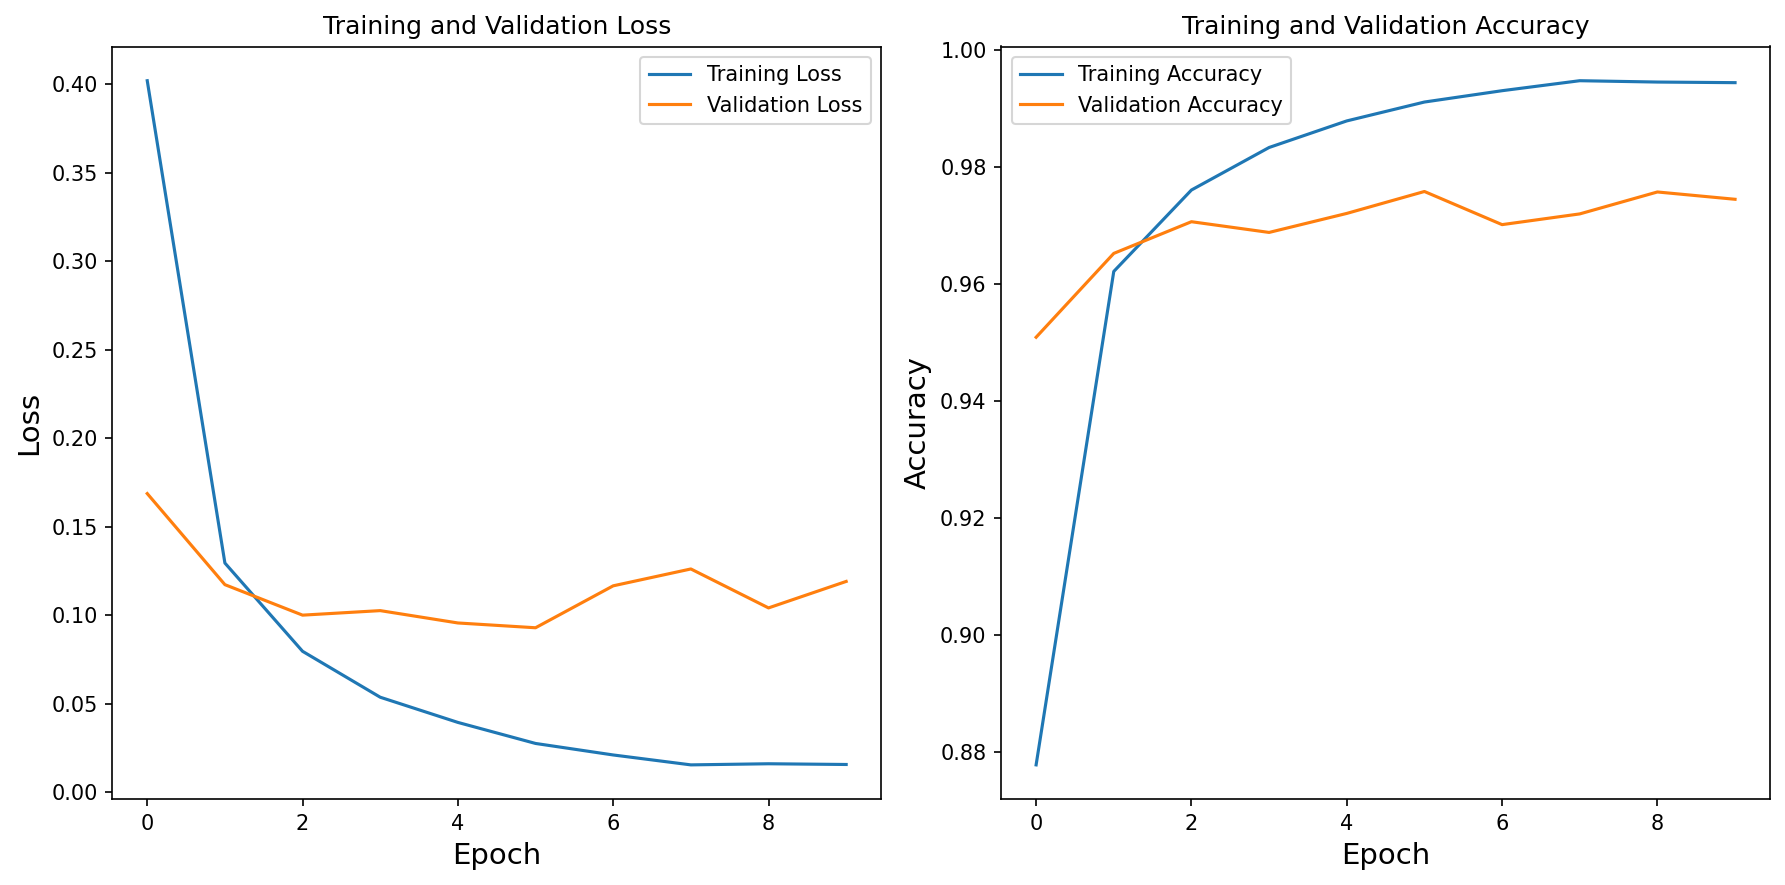

Test Accuracy 93.0%


In [61]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(28,28,1)),
    keras.layers.Conv2D(8, (5, 5), activation='relu'),
    keras.layers.Conv2D(16, (5, 5), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=10, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

Increasing the size of the kernels for the convolution layers dropped the number of parameters by a third and improved performance to 93.0%.  It also would have benefitted from stopping after 3 epochs.

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 26, 26, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 24, 24, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_30 (Flatten)                 │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_104 (Dense)                    │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_105 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_106 (Dense)                    │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,189,930 (4.54 MB)

 Trainable params: 1,189,930 (4.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7556 - loss: 0.7901 - val_accuracy: 0.9209 - val_loss: 0.2651
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9333 - loss: 0.2203 - val_accuracy: 0.9422 - val_loss: 0.1945
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9588 - loss: 0.1406 - val_accuracy: 0.9582 - val_loss: 0.1437
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9705 - loss: 0.0993 - val_accuracy: 0.9588 - val_loss: 0.1452
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9803 - loss: 0.0684 - val_accuracy: 0.9663 - val_loss: 0.1194
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9845 - loss: 0.0545 - val_accuracy: 0.9649 - val_loss: 0.1247
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9890 - loss: 0.0379 - val_accuracy: 0.9682 - val_loss: 0.1163
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9935 - loss: 0.0250 - val_accu

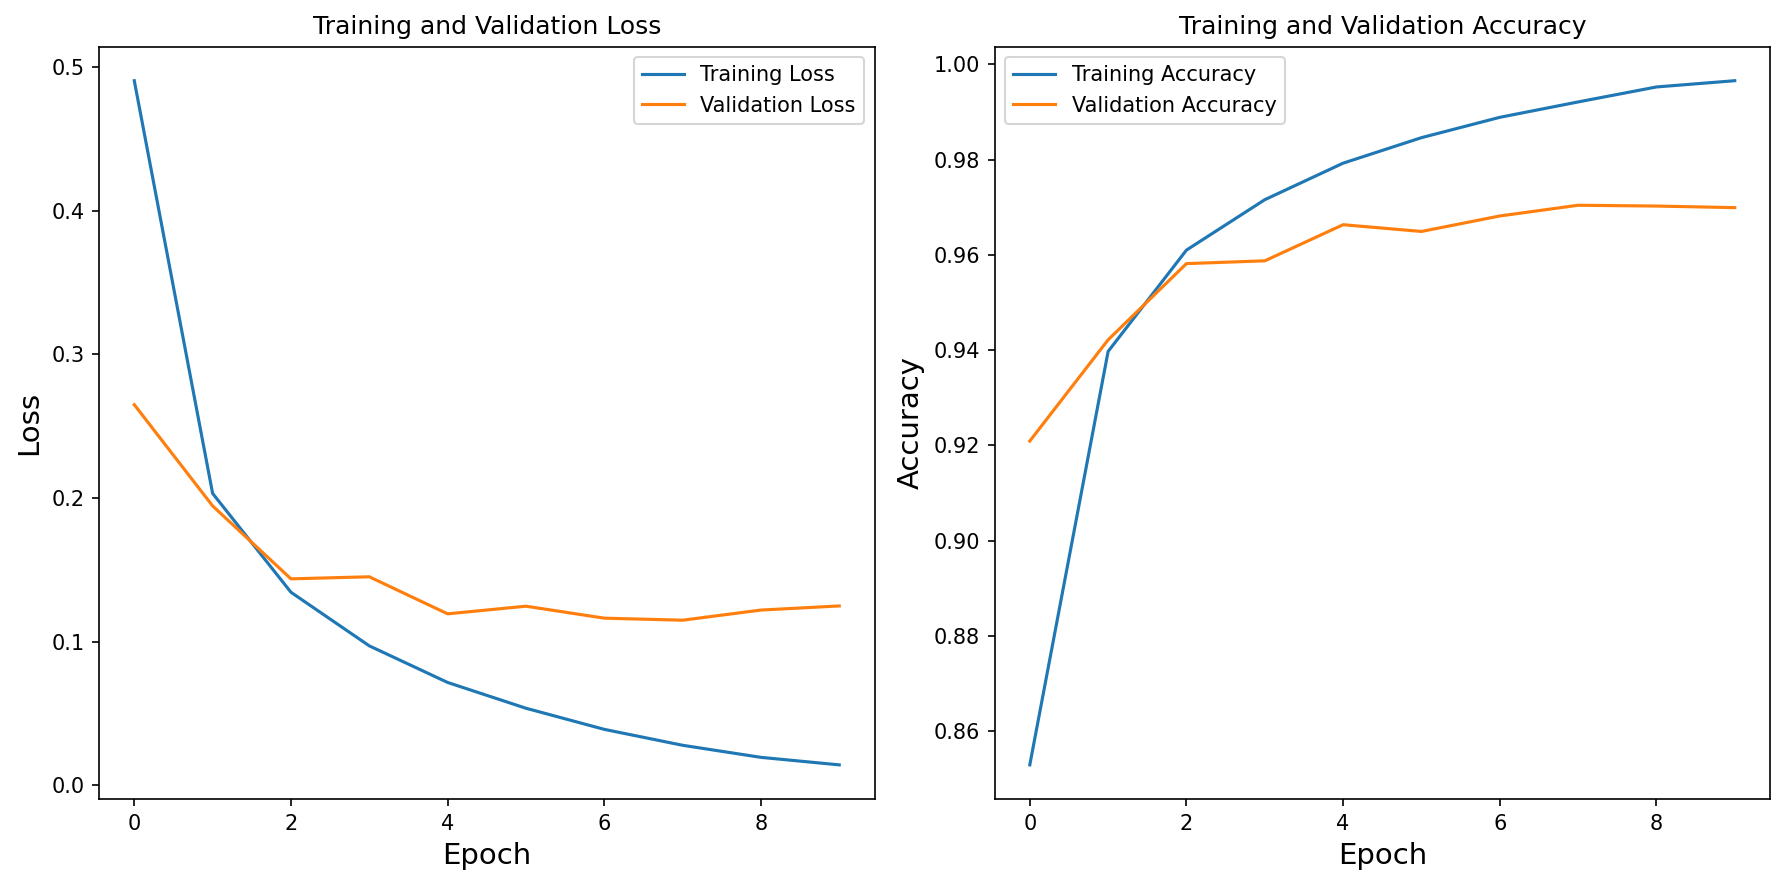

Test Accuracy 92.1%


In [62]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(28,28,1)),
    keras.layers.Conv2D(8, (3, 3), activation='relu'),
    keras.layers.Conv2D(16, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=10, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

Removing the max pooling layer jumped the number of parameters by a factor of 4 (1.2M) and actually dropped accuracy to 92.1% from the baseline 92.8%.  It seemed like it would have benefited from fewer epochs as well.

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 24, 24, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 8, 8, 32)            │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_31 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_107 (Dense)                    │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_108 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_109 (Dense)                    │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,818 (343.04 KB)

 Trainable params: 87,818 (343.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7322 - loss: 0.8739 - val_accuracy: 0.9330 - val_loss: 0.2174
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9438 - loss: 0.1800 - val_accuracy: 0.9578 - val_loss: 0.1403
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9685 - loss: 0.1040 - val_accuracy: 0.9679 - val_loss: 0.1071
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9777 - loss: 0.0737 - val_accuracy: 0.9728 - val_loss: 0.0919
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9832 - loss: 0.0564 - val_accuracy: 0.9753 - val_loss: 0.0866
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9881 - loss: 0.0429 - val_accuracy: 0.9725 - val_loss: 0.0952
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9888 - loss: 0.0373 - val_accuracy: 0.9777 - val_loss: 0.0811
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9911 - loss: 0.0277 - val_accuracy: 0.

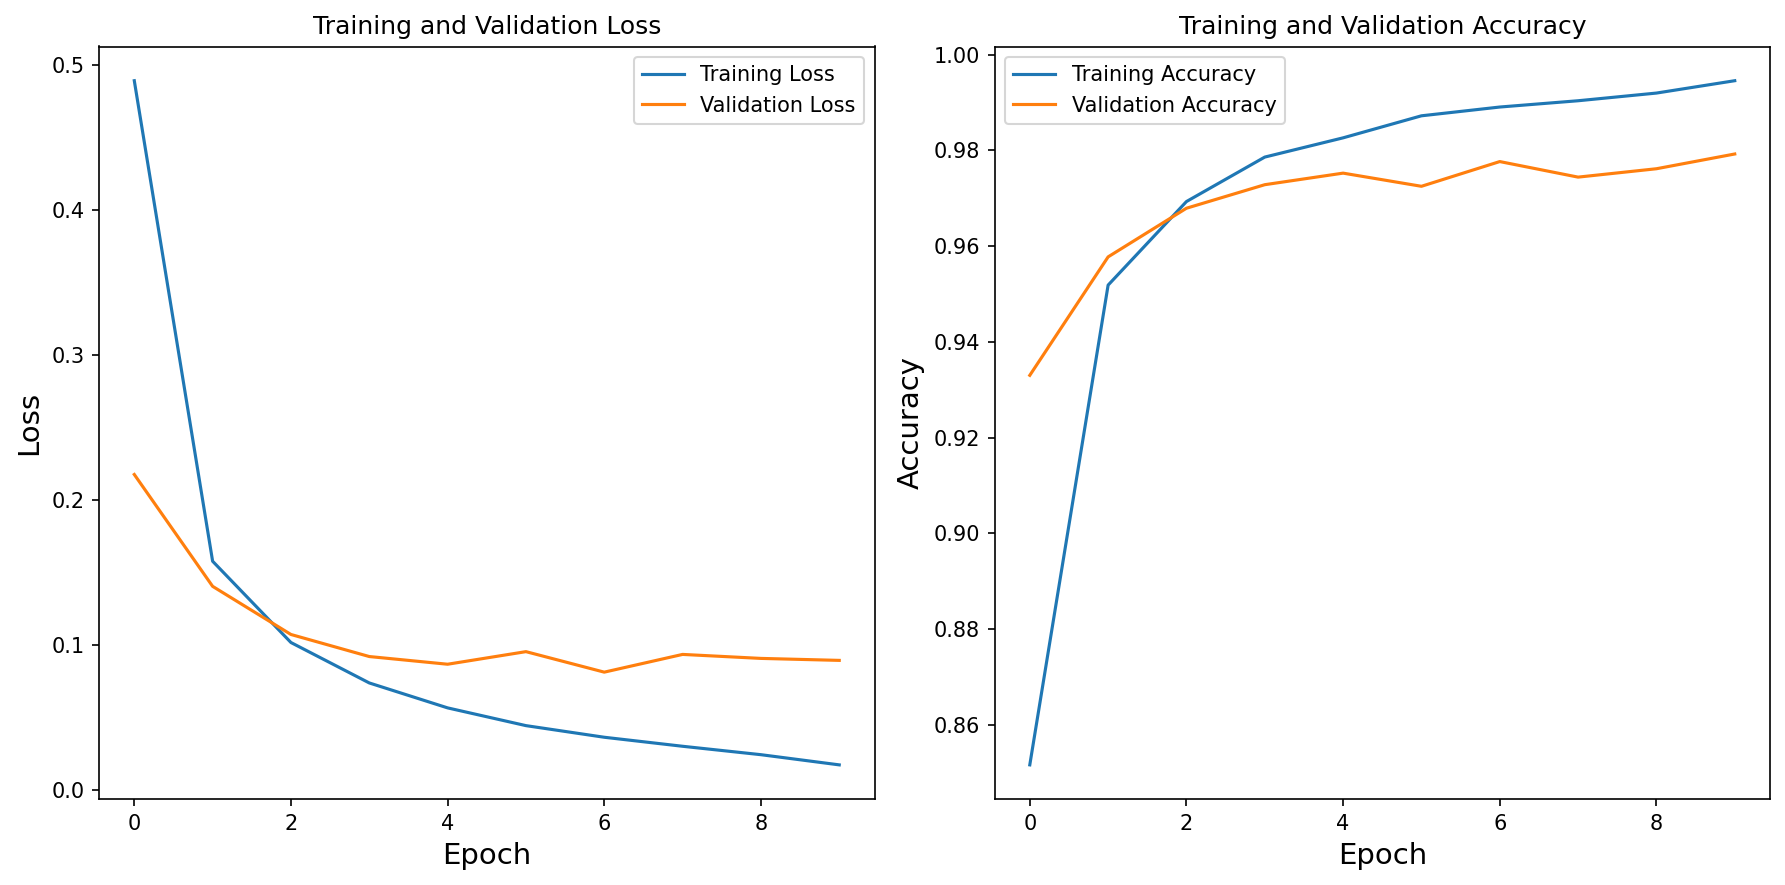

Test Accuracy 94.5%


In [63]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(28,28,1)),
    keras.layers.Conv2D(16, (5, 5), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(32, (5, 5), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=10, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

Using a combination of more and larger kernels for the 2 convolutional layers and also adding a max pooling layer between them, we are able to get a 94.5% accuracy vs. the baseline 92.8%.  We are also only having to learn 87k parameters vs. the baseline 300k.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


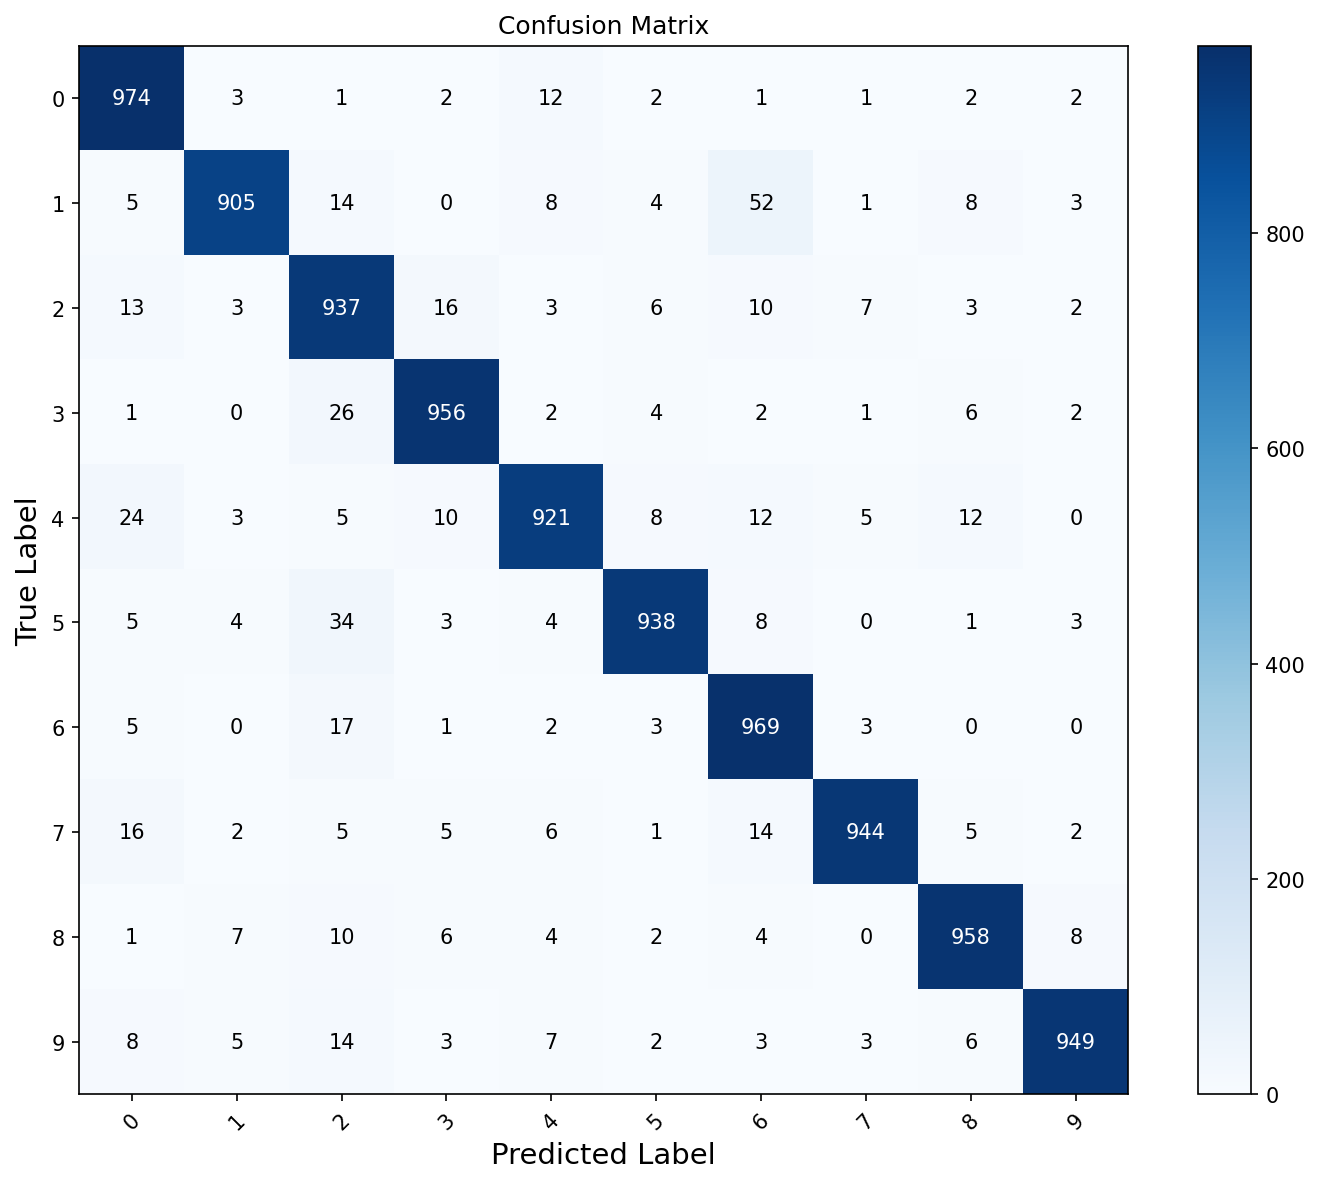

In [64]:
plot_confusion_matrix(model)

From the confusion matrix we can see that our worst performance is for class 1 where we misclassified 52 images as class 6 instead.
Our second worst offender is class 5 where we misclassified 34 images as class 2.